<a href="https://colab.research.google.com/github/SethJorissen/ANM_anomalies_project/blob/main/ANM_anomalies_project_phase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANM anomaly detection project - phase 2

Tsinghua 2023, produced by Aris Dressino and Seth Jorissen

## 1. initial set up

- fetch data for analysis
- import needed libraries

In [1]:
# fetch phase 1 and 2 data from github to colab working directory - run once
# consider using another method if working from local client
%%capture
#import shutil
#shutil.rmtree('/content/phase1')
!apt install subversion
!svn checkout https://github.com/SethJorissen/ANM_anomalies_project/trunk/phase1
!svn checkout https://github.com/SethJorissen/ANM_anomalies_project/trunk/phase2

In [2]:
# needed libraries
import glob
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np
from tqdm import tqdm
from typing import Dict, List
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense, RepeatVector, TimeDistributed
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import pearsonr
from typing import List, Dict, Tuple, Set
import shutil

##2. Exploratory data analysis

- provide summary statistics and relevant analysis of the data
- plot relevant features of the dataset against timestamp



In [3]:
# import train set
# Set the path to the directory containing the CSV files
path = 'phase2/dataset/train/processed'

# Get a list of all CSV files in the directory
files = glob.glob(os.path.join(path, '*.csv'))

df_list = []
# Iterate over each file, read it into a DataFrame, and add a new column with the filename
for file in files:
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file)
    
    # Add a new column with the filename without the extension
    filename = os.path.splitext(os.path.basename(file))[0]
    df['service'] = filename
    df_list.append(df)

# Concatenate all dataframes into a single dataframe
train = pd.concat(df_list, ignore_index=True)

train.head(5)

,timestamp,container_network_receive_packets_dropped.eth0,container_spec_cpu_shares,container_spec_memory_swap_limit_MB,container_fs_writes_MB./dev/vda,container_network_transmit_packets_dropped.eth0,container_network_receive_errors.eth0,container_fs_writes_merged./dev/vda1,container_threads_max,container_fs_write_seconds./dev/vda1,...,container_spec_cpu_period,container_memory_swap,container_threads,container_network_transmit_errors.eth0,container_spec_memory_limit_MB,container_fs_reads_merged./dev/vda1,container_network_transmit_MB.eth0,container_cpu_system_seconds,container_cpu_load_average_10s,service
0,1647619260,0.0,102.0,128.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,23.0,0.0,128.0,0.0,4.053216,0.020,0.0,frontend2-0
1,1647619320,0.0,102.0,128.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,23.0,0.0,128.0,0.0,4.177649,0.025,0.0,frontend2-0
2,1647619380,0.0,102.0,128.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,23.0,0.0,128.0,0.0,4.150427,0.040,0.0,frontend2-0
3,1647619440,0.0,102.0,128.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,23.0,0.0,128.0,0.0,4.145440,0.030,0.0,frontend2-0
4,1647619500,0.0,102.0,128.0,0.0,0.0,0.0,0.0,0.0,0.0,...,100000.0,0.0,23.0,0.0,128.0,0.0,4.105330,0.020,0.0,frontend2-0


In [4]:
# describe numerical metrics of train dataset
train.describe()

,timestamp,container_network_receive_packets_dropped.eth0,container_spec_cpu_shares,container_spec_memory_swap_limit_MB,container_fs_writes_MB./dev/vda,container_network_transmit_packets_dropped.eth0,container_network_receive_errors.eth0,container_fs_writes_merged./dev/vda1,container_threads_max,container_fs_write_seconds./dev/vda1,...,container_cpu_cfs_periods,container_spec_cpu_period,container_memory_swap,container_threads,container_network_transmit_errors.eth0,container_spec_memory_limit_MB,container_fs_reads_merged./dev/vda1,container_network_transmit_MB.eth0,container_cpu_system_seconds,container_cpu_load_average_10s
count,6.043800e+04,60438.0,57560.000000,57560.000000,57560.0,60438.0,60438.0,57560.0,57560.0,57560.0,...,57560.000000,57560.0,57560.0,57560.000000,60438.0,57560.000000,57560.0,60438.000000,57560.000000,57560.0
mean,1.647662e+09,0.0,206.700000,368.125000,0.0,0.0,0.0,0.0,0.0,0.0,...,113.878423,100000.0,0.0,25.588870,0.0,368.125000,0.0,1.341939,0.060221,0.0
std,2.492441e+04,0.0,95.695972,280.152678,0.0,0.0,0.0,0.0,0.0,0.0,...,97.499338,0.0,0.0,4.989798,0.0,280.152678,0.0,1.425130,0.100049,0.0
min,1.647619e+09,0.0,102.000000,128.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,100000.0,0.0,15.000000,0.0,128.000000,0.0,0.049372,0.000000,0.0
25%,1.647641e+09,0.0,102.000000,224.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,25.000000,100000.0,0.0,21.000000,0.0,224.000000,0.0,0.381905,0.010000,0.0
50%,1.647662e+09,0.0,204.000000,256.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,98.000000,100000.0,0.0,27.000000,0.0,256.000000,0.0,0.939109,0.025000,0.0
75%,1.647684e+09,0.0,204.000000,465.500000,0.0,0.0,0.0,0.0,0.0,0.0,...,174.000000,100000.0,0.0,29.000000,0.0,465.500000,0.0,1.738056,0.055000,0.0
max,1.647706e+09,0.0,409.000000,1025.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,506.000000,100000.0,0.0,41.000000,0.0,1025.000000,0.0,8.847941,0.670000,0.0


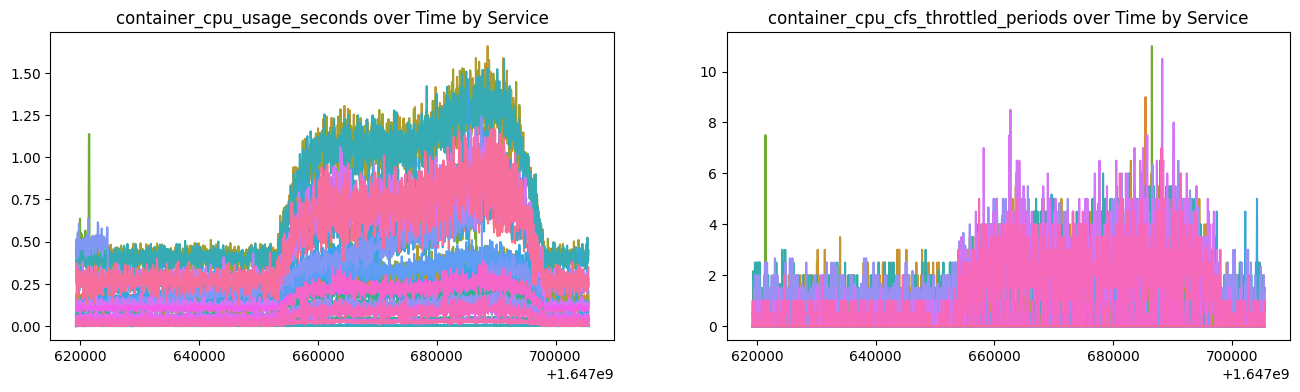

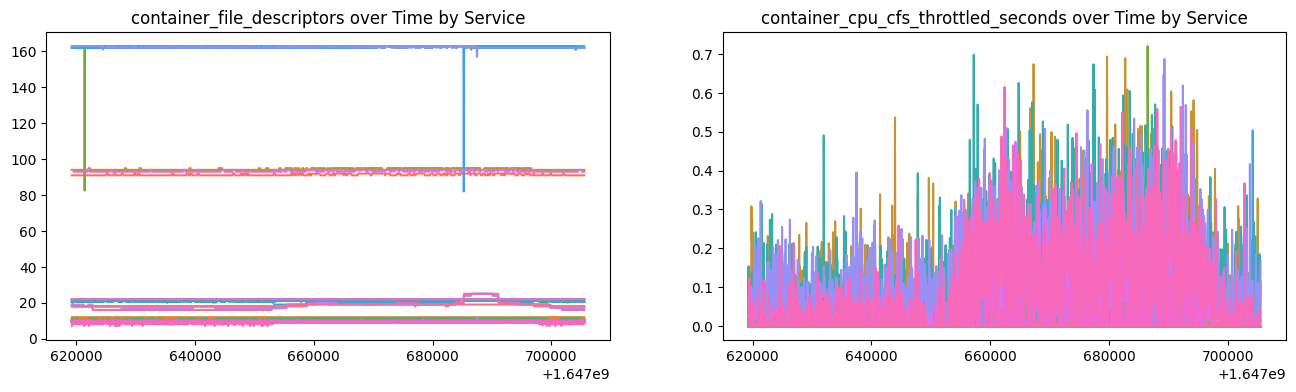

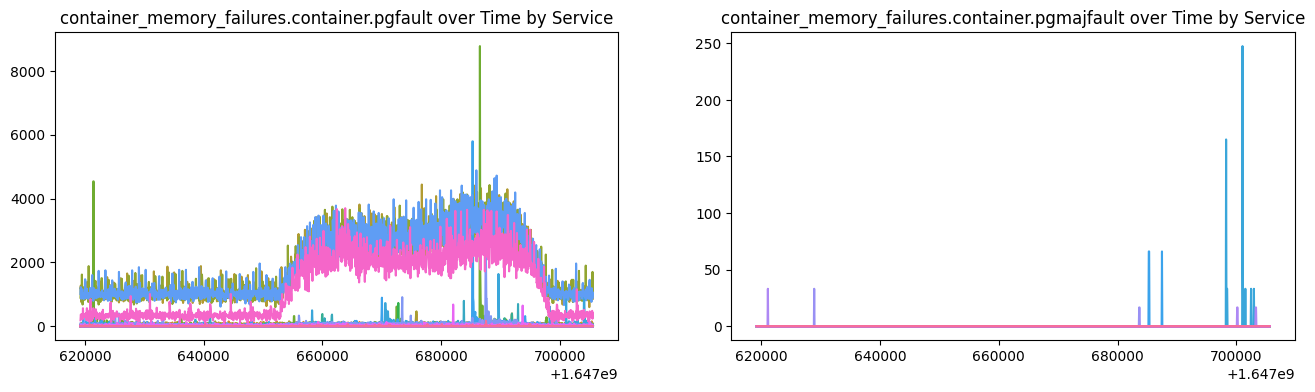

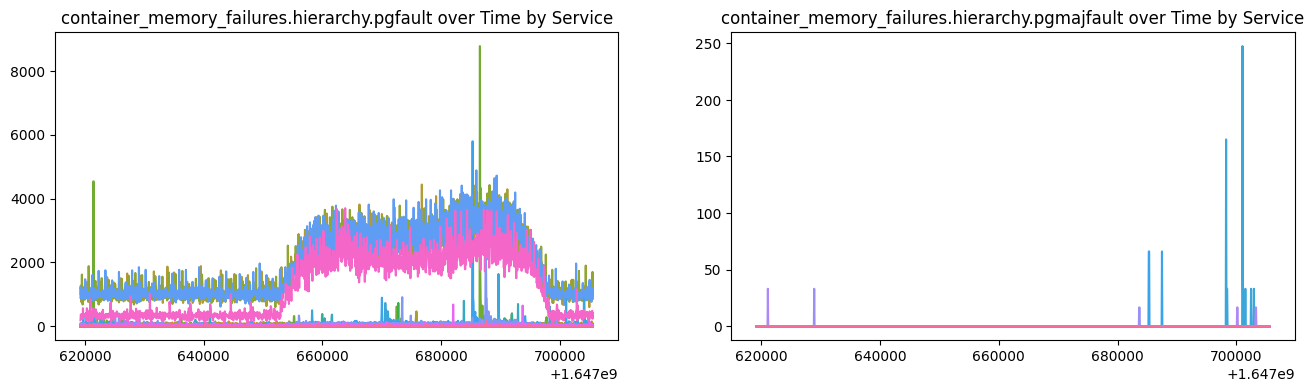

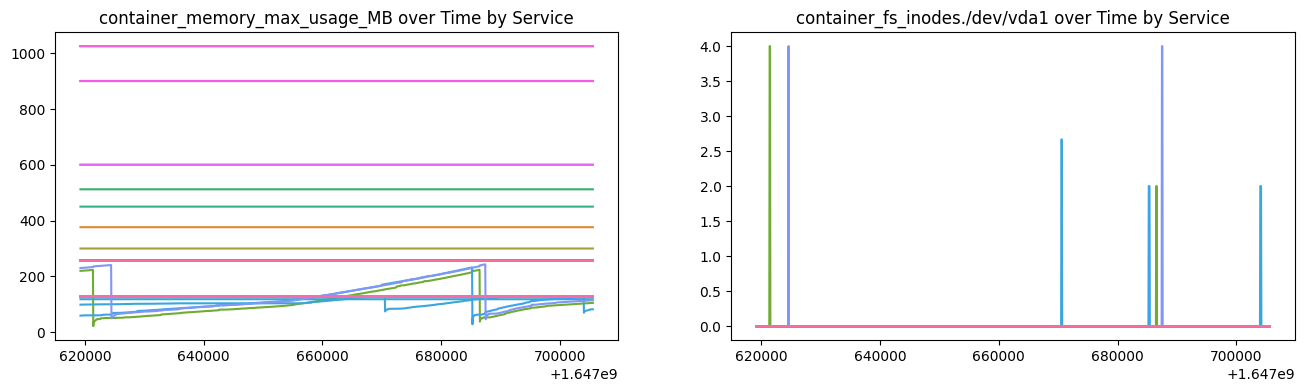

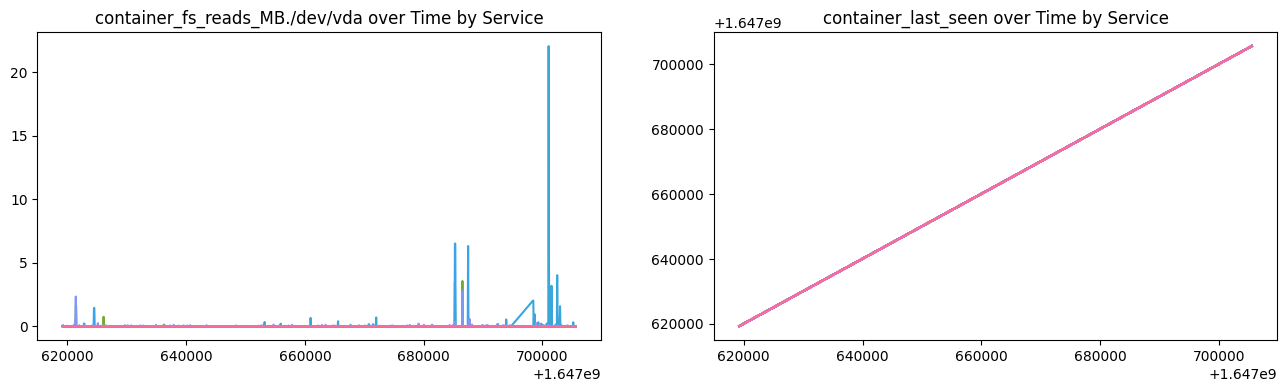

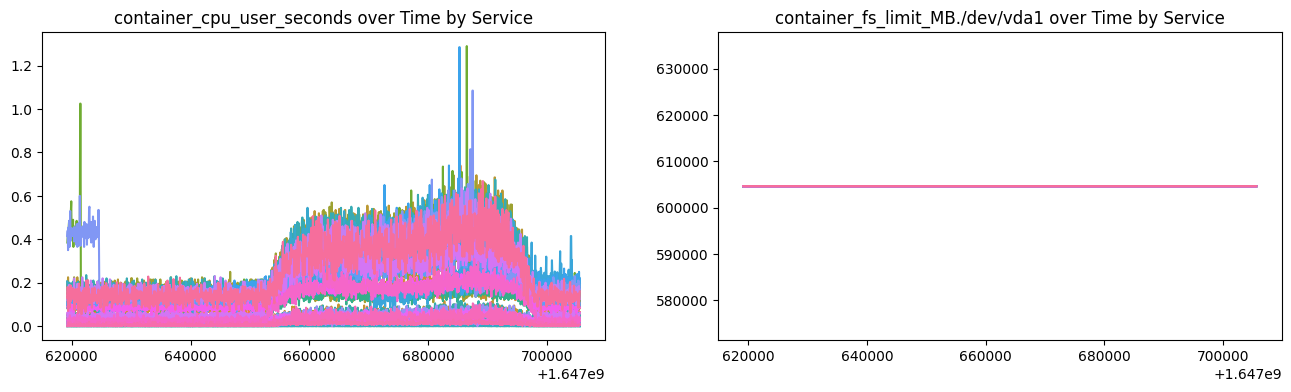

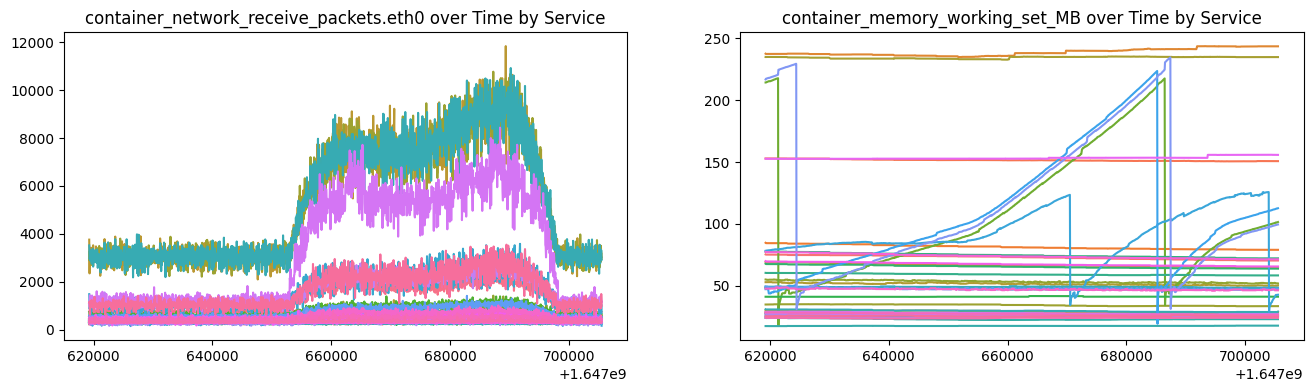

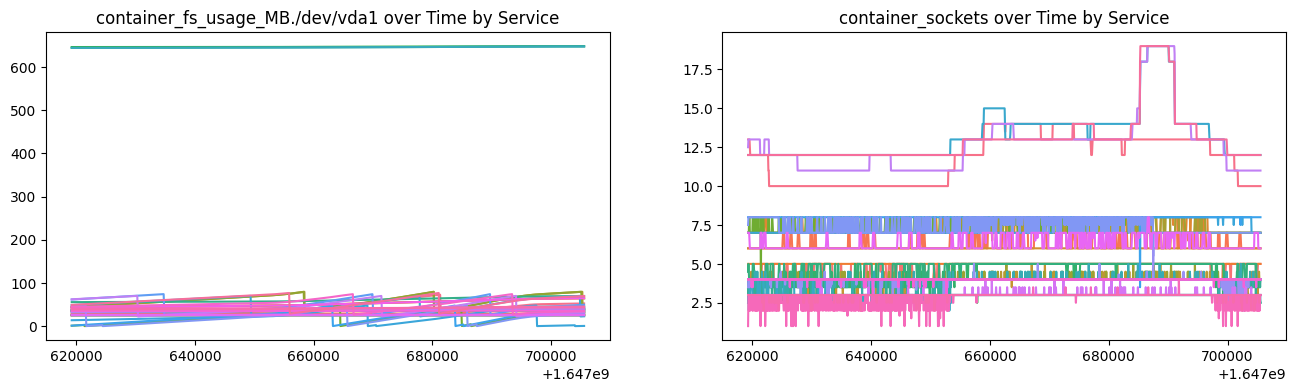

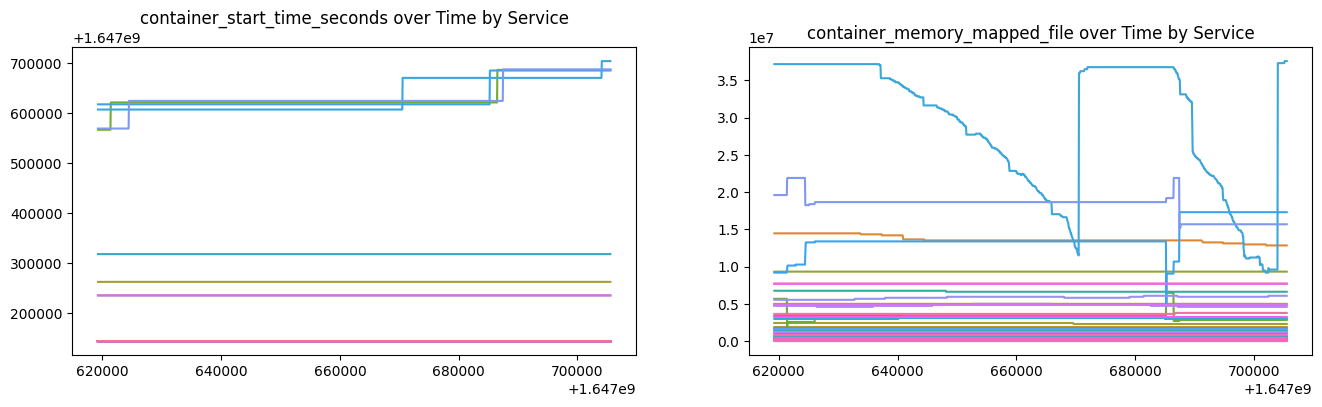

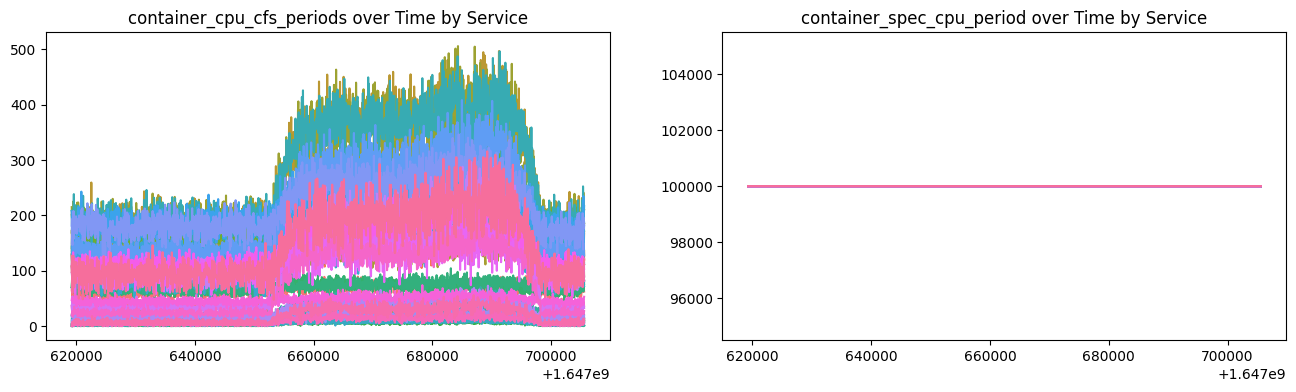

In [5]:
# Loop over all columns in the DataFrame except "timestamp" and "service"
cols = train.columns.drop(["timestamp", "service"])
for i in range(0, len(cols), 2):
    col1 = cols[i]
    col2 = cols[i+1] if i+1 < len(cols) else None

    # Check if all values in the column are 0 or the same value
    if (len(train[col1].unique()) == 1 or train[col1].sum() == 0) or (not col2 or (len(train[col2].unique()) == 1 or train[col2].sum() == 0)):
        continue

    # Check if the values are equal when grouped by service for both columns
    if col2:
        grouped1 = train.groupby('service')[col1].nunique()
        grouped2 = train.groupby('service')[col2].nunique()
        if len(grouped1.unique()) == 1 or len(grouped2.unique()) == 1:
            continue
        
    # Create a new row of subplots with 2 columns
    fig, axs = plt.subplots(1, 2, figsize=(16, 4))

    # Create the first plot in the left column
    sns.lineplot(x="timestamp", y=col1, hue="service", data=train, ax=axs[0])
    axs[0].set_title(f"{col1} over Time by Service")

    # Remove the legend from the first plot
    axs[0].get_legend().remove()

    # Create the second plot in the right column if there is a second column
    if col2:
        sns.lineplot(x="timestamp", y=col2, hue="service", data=train, ax=axs[1])
        axs[1].set_title(f"{col2} over Time by Service")

        # Remove the legend from the second plot
        axs[1].get_legend().remove()

    # Remove axis labels from all subplots
    for ax in axs:
        ax.set_xlabel('')
        ax.set_ylabel('')

    # Set the height of all subplots to the same value
    fig.subplots_adjust(hspace=0.4)

    # Add a border to the row of subplots
    for ax in axs:
        ax.spines['top'].set_visible(True)
        ax.spines['right'].set_visible(True)

    # Show the row of subplots
    plt.show()



##3. Anomaly Localization

This model first creates an anomaly detection model for all microservices using a LSTM AE. This model will return a series of anomaly scores over time and a boolean which indicates whether the threshold was breached.

Then a root cause analasis starts. The edges and nodes of the topology graph will be given weights. The nodes of this graph will be ranked by PageRank.

###3.1 Data management

This class will prepare the data in the test/train folders. Given a folder it will load all csv files and and put them in a dictionary with their name as key. It gets rid of NaN values and removes irrelavent columns.

In [6]:
class DataManager:
    def __init__(self, 
                 data_path: str,
                 train: bool = False,
                 ignore_columns=None):
        if ignore_columns is None:
            ignore_columns = [
                'timestamp',
                'container_start_time_seconds',
                'container_last_seen']
        self.data_path = data_path
        self.ignore_columns = ignore_columns
        self.train = train

        # Load from file
        self.data: Dict[str, np.ndarray] = {}
        self.columns: List[str] = []
        self.__load()

    def __fill_na(self, df: pd.DataFrame):
        if self.train:
            df.interpolate(method='linear', inplace=True)
        df.fillna(0.0, inplace=True)

    def __load(self):
        for file in os.listdir(self.data_path):
            if not file.endswith('.csv'):
                continue

            cur_df = pd.read_csv(os.path.join(self.data_path, file), engine='c')
            self.__fill_na(cur_df)
            self.columns = sorted([i for i in cur_df.columns.values if i not in self.ignore_columns])
            self.data[file[:-4]] = cur_df[self.columns].values

    def get(self, s: str) -> np.ndarray:
        return self.data[s]

###3.2 Anomaly detection

The anomaly detection model uses two classes:
- $LSTMAEDetector$ holds a LSTM AE to detect anomolies in a microservice. Before fitting the model, it first prepares the input data by scaling and creating sequences. Then it defines the model and fits it on the data. Finally the loss is scaled so all microservices can use the same threshold. To make a prediction, the data is prepared the same way and the scaled reconstruction loss of the model is calculated. This will be the anomaly score. All the anomaly scores will be returned and it will also check whether the threshold was breached at any point.

- The anomaly detector class will create and fit the LSTM AE Detectors of all microservices. When detecting an anomoly, it will call the detector of all microservices and return whether they encountered an anomaly and their anomaly scores.





In [7]:
# DBSCAN

from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances

class GraphBasedDetector:
    def __init__(self):
        self.detector = None

    def fit(self, data: np.ndarray):
        # Compute pairwise distances between data points
        distances = pairwise_distances(data)

        # Use DBSCAN for clustering
        self.detector = DBSCAN(eps=0.5, min_samples=5)
        self.detector.fit(distances)

    def decision_function(self, data: np.ndarray):
        # Data: [timesteps x features]
        distances = pairwise_distances(data)
        labels = self.detector.labels_

        # Calculate anomaly scores based on cluster membership
        anomaly_scores = np.zeros_like(labels, dtype=float)
        unique_labels = np.unique(labels)

        for label in unique_labels:
            if label == -1:  # Outliers
                anomaly_scores[labels == label] = 1.0
            else:
                cluster_indices = np.where(labels == label)[0]
                cluster_distances = distances[cluster_indices][:, cluster_indices]
                min_distances = np.min(cluster_distances, axis=1)
                max_distance = np.max(min_distances)
                anomaly_scores[labels == label] = 1.0 - min_distances / max_distance

        return anomaly_scores

class AnomalyDetector:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.detector_dict: Dict[str, Any] = {}

    def fit(self, data: DataManager):
        for s in tqdm(list(data.data.keys()), desc='Fitting detector(s)'):
            detector = GraphBasedDetector()
            detector.fit(data.get(s))
            self.detector_dict[s] = detector

    def decision_function(self, data: np.ndarray):
        anomalies: Dict[str, bool] = {}
        anomaly_scores: Dict[str, np.ndarray] = {}

        for k, v in data.data.items():
            detector = self.detector_dict[k]
            scores = detector.decision_function(v)
            anomaly_scores[k] = scores
            anomalies[k] = scores > self.hyper_params['anomaly_threshold']

        return anomalies, anomaly_scores

    def detect(self, data: DataManager):
        # Simply return the max anomaly degree of all metrics
        result: Dict[str, float] = {}

        for k, v in data.data.items():
            detect_result = self.detector_dict[k].decision_function(v)

            assert type(detect_result) == np.ndarray
            result[k] = np.mean(detect_result)

        return result


In [8]:
# GRAPH BASED DETECTOR

from sklearn.neighbors import LocalOutlierFactor

class GraphBasedDetector:
    def __init__(self):
        self.detector = None

    def fit(self, data: np.ndarray):
        self.detector = LocalOutlierFactor(contamination='auto')
        self.detector.fit(data)

    def decision_function(self, data: np.ndarray):
        # Data: [timesteps x features]
        scores = self.detector.negative_outlier_factor_
        anomaly_scores = np.ones_like(scores) - (1 + scores) / 2
        return anomaly_scores

class AnomalyDetector:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.detector_dict: Dict[str, Any] = {}

    def fit(self, data: DataManager):
        for s in tqdm(list(data.data.keys()), desc='Fitting detector(s)'):
            detector = GraphBasedDetector()
            detector.fit(data.get(s))
            self.detector_dict[s] = detector

    def decision_function(self, data: np.ndarray):
        anomalies: Dict[str, bool] = {}
        anomaly_scores: Dict[str, np.ndarray] = {}

        for k, v in data.data.items():
            detector = self.detector_dict[k]
            scores = detector.decision_function(v)
            anomaly_scores[k] = scores
            anomalies[k] = scores > self.hyper_params['anomaly_threshold']

        return anomalies, anomaly_scores

    def detect(self, data: DataManager):
        # Simply return the max anomaly degree of all metrics
        result: Dict[str, float] = {}

        for k, v in data.data.items():
            detect_result = self.detector_dict[k].decision_function(v)

            assert type(detect_result) == np.ndarray
            result[k] = np.mean(detect_result)

        return result


In [9]:
# SVM BASED DETECTOR

from sklearn.svm import OneClassSVM

class SVMBasedDetector:
    def __init__(self):
        self.detector = None

    def fit(self, data: np.ndarray):
        self.detector = OneClassSVM(nu=0.1)
        self.detector.fit(data)

    def decision_function(self, data: np.ndarray):
        # Data: [timesteps x features]
        scores = self.detector.decision_function(data)
        anomaly_scores = np.ones_like(scores) - (1 + scores) / 2
        return anomaly_scores

class AnomalyDetector:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.detector_dict: Dict[str, Any] = {}

    def fit(self, data: DataManager):
        for s in tqdm(list(data.data.keys()), desc='Fitting detector(s)'):
            detector = SVMBasedDetector()
            detector.fit(data.get(s))
            self.detector_dict[s] = detector

    def decision_function(self, data: np.ndarray):
        anomalies: Dict[str, bool] = {}
        anomaly_scores: Dict[str, np.ndarray] = {}

        for k, v in data.data.items():
            detector = self.detector_dict[k]
            scores = detector.decision_function(v)
            anomaly_scores[k] = scores
            anomalies[k] = scores > self.hyper_params['anomaly_threshold']

        return anomalies, anomaly_scores

    def detect(self, data: DataManager):
        # Simply return the max anomaly degree of all metrics
        result: Dict[str, float] = {}

        for k, v in data.data.items():
            detect_result = self.detector_dict[k].decision_function(v)

            assert type(detect_result) == np.ndarray
            result[k] = np.mean(detect_result)

        return result

In [10]:
# ISOLATION FOREST

from sklearn.ensemble import IsolationForest

class IsolationForestDetector:
    def __init__(self):
        self.detector = None

    def fit(self, data: np.ndarray):
        self.detector = IsolationForest()
        self.detector.fit(data)

    def decision_function(self, data: np.ndarray):
        scores = self.detector.decision_function(data)
        anomaly_scores = np.ones_like(scores) - (1 + scores) / 2
        return anomaly_scores

class AnomalyDetector:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.detector_dict = {}

    def fit(self, data: DataManager):
        for s in tqdm(list(data.data.keys()), desc='Fitting detector(s)'):
            detector = IsolationForestDetector()
            detector.fit(data.get(s))
            self.detector_dict[s] = detector

    def decision_function(self, data: np.ndarray):
        anomalies = {}
        anomaly_scores = {}

        for k, v in data.data.items():
            detector = self.detector_dict[k]
            scores = detector.decision_function(v)
            anomaly_scores[k] = scores
            anomalies[k] = scores > self.hyper_params['anomaly_threshold']

        return anomalies, anomaly_scores

    def detect(self, data: DataManager):
        result = {}

        for k, v in data.data.items():
            detect_result = self.detector_dict[k].decision_function(v)
            assert isinstance(detect_result, np.ndarray)
            result[k] = np.mean(detect_result)

        return result


In [11]:
# K SIGMA DETECTOR

class KSigmaDetecor:
    def __init__(self):
        pass

    def fit(self, data: np.ndarray):
        self.lam = np.mean(data, axis=0, keepdims=True)

    def decision_function(self, data: np.ndarray):
        # Data: [timesteps x features]

        data_lam = np.mean(data, axis=0, keepdims=True)

        return np.ones_like(data_lam) - np.exp(-1*np.square(np.sqrt(self.lam) - np.sqrt(data_lam)))


class AnomalyDetector:
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params
        self.detector_dict: Dict[str, KSigmaDetecor] = {}

    def fit(self, data: DataManager):
        for s in tqdm(list(data.data.keys()), desc='Fitting detector(s)'):
            detector = KSigmaDetecor()
            detector.fit(data.get(s))
            self.detector_dict[s] = detector

    def detect(self, data: DataManager):
        # Simply return the max anomaly degree of all metrics
        result: Dict[str, float] = {}

        for k, v in data.data.items():
            detect_result = self.detector_dict[k].decision_function(v)

            assert type(detect_result) == np.ndarray
            result[k] = np.mean(detect_result)

        return result

###3.3 Root cause localization
The root cause localization will rank all microservices based on the probability that they are the root cause of the anomaly. The ranker has to be initialized with an anomalydetector. To start ranking the microservices their anomaly scores are calculated. Afterwards, the algorithm will use following scoring formula to perform a simplified version of pagerank:

$$v_{t+1} = (1 - c)Pv_t + cu$$

where $v$ holds the score of all nodes, $P$ is a matrix holding the weights of all edges and $u$ is a vector with for each microservice, the max anomaly score. For all edges in the topology, $P$ is equal to the pearson correlation of the nodes it connects and 0 for all other edges. This means that the score for the nodes $v$ is parially defined by the anomaly score of the microservice and partially by the score of their parent nodes. However, that depends on the corralation between their anomaly scores.

This algrorithm is based on the MicroRCA algorithm, but we do not have all the data they had.

Li Wu, Johan Tordsson, Erik Elmroth, Odej Kao. MicroRCA: Root Cause Localization of Performance
Issues in Microservices. IEEE/IFIP Network Operations and Management Symposium (NOMS), Apr
2020, Budapest, Hungary. ffhal-02441640f

https://inria.hal.science/hal-02441640

In [12]:
class Ranker:
    """
        This is a naive ranking algorithm, which simply rank according to the anomaly scores.
    """
    def __init__(self, hyper_params):
        self.hyper_params = hyper_params

        self.train_data = DataManager(hyper_params['train_dir'])
        self.anomaly_detector = AnomalyDetector(hyper_params)
        self._init_ranker()
    
    def _init_ranker(self):
        self.anomaly_detector.fit(self.train_data)

    def rank(self, case_dir: str):     
        # Load test data
        test_data = DataManager(case_dir)

        # Detect anomaly
        anomaly_score = self.anomaly_detector.detect(test_data)

        # TODO: You need to modify the ranking algorithm to achieve better results!   
        # This is a naive ranking algorithm, which simply rank according to the anomaly scores.
        rank_result = sorted(list(anomaly_score.keys()), key=lambda x: anomaly_score[x], reverse=True)

        # Sort services based on their anomaly scores
        rank_result = sorted(anomaly_score.keys(), key=lambda x: anomaly_score[x], reverse=True)

        return rank_result


###3.4 Training

In [13]:
"""
hyper_params = {
    'train_dir': 'phase2/dataset/train/processed',
    'test_dir': 'phase2/dataset/test/processed',
    'label_path': 'phase2/dataset/test/label.json',
    'topology': 'phase1/dataset/topology/service_topology.json'
}
"""

hyper_params = {
    'train_dir': 'phase1/dataset/train/processed',
    'test_dir': 'phase1/dataset/test/processed',
    'label_path': 'phase1/dataset/test/label.json',
    'topology': 'phase1/dataset/topology/service_topology.json'
}



ranker = Ranker(hyper_params)

Fitting detector(s): 100%|██████████| 42/42 [00:00<00:00, 5155.72it/s]


##4. evaluation, prediction and metrics

- evaluate test set anomalies and rank them
- compare labels with predicted ranking
- information regarding indexing are provided

In [14]:
# Generate a list of lists containing the labels for the test set of phase 1 only
# Load the JSON file
with open('phase1/dataset/test/label.json', 'r') as json_file:
    data = json.load(json_file)

df_labels = pd.DataFrame(data)
labels = df_labels.values.tolist()

print(labels)

[[1648486942, 'emailservice-0'], [1648491433, 'recommendationservice2-0'], [1648492533, 'currencyservice-1'], [1648507813, 'paymentservice-1'], [1648512399, 'productcatalogservice-0'], [1648518075, 'shippingservice2-0'], [1648520175, 'productcatalogservice-0'], [1648522456, 'paymentservice-0'], [1648525065, 'frontend2-0'], [1648540678, 'shippingservice-2'], [1648541744, 'frontend2-0'], [1648552790, 'adservice2-0'], [1648558337, 'recommendationservice-2'], [1648560649, 'cartservice-2'], [1648561519, 'emailservice-2'], [1648565706, 'frontend2-0'], [1648550137, 'cartservice-1'], [1648525567, 'cartservice-1'], [1648491097, 'paymentservice-2'], [1648494319, 'adservice-2'], [1648506344, 'productcatalogservice-1'], [1648516367, 'productcatalogservice-0'], [1648528148, 'recommendationservice-1'], [1648528984, 'shippingservice-2'], [1648531433, 'cartservice-2'], [1648540897, 'shippingservice-2'], [1648549152, 'emailservice-2'], [1648551076, 'shippingservice-2'], [1648552118, 'recommendationserv

In [15]:
result_list = []
case_idx: int = 0
with tqdm(total=len(os.listdir(hyper_params['test_dir']))) as t:
    while True:
        case_dir = os.path.join(hyper_params['test_dir'], str(case_idx))
        if not os.path.exists(case_dir):
            break
        t.set_description(f"Ranking {case_dir}")

        cur_rank = ranker.rank(case_dir)
        print("")
        print("the anomaly label is: ", labels[case_idx])
        print(cur_rank)
        for l in cur_rank:
          if l == labels[case_idx][1]:
            print("in the current rank, the original amonaly is in position ", cur_rank.index(l))
            break
        print("\n")
        result_list.append(cur_rank)

        # Update tqdm
        t.update()
        case_idx += 1

Ranking phase1/dataset/test/processed/2:   2%|▏         | 2/92 [00:00<00:16,  5.45it/s]


the anomaly label is:  [1648486942, 'emailservice-0']
['cartservice2-0', 'checkoutservice-2', 'checkoutservice-1', 'checkoutservice-0', 'emailservice-0', 'currencyservice2-0', 'cartservice-1', 'currencyservice-2', 'checkoutservice2-0', 'productcatalogservice2-0', 'cartservice-2', 'frontend2-0', 'cartservice-0', 'frontend-1', 'recommendationservice2-0', 'currencyservice-0', 'currencyservice-1', 'paymentservice2-0', 'frontend-0', 'frontend-2', 'shippingservice-2', 'shippingservice-0', 'adservice-0', 'paymentservice-1', 'adservice-1', 'recommendationservice-0', 'adservice2-0', 'shippingservice2-0', 'productcatalogservice-2', 'recommendationservice-2', 'productcatalogservice-0', 'shippingservice-1', 'productcatalogservice-1', 'adservice-2', 'recommendationservice-1', 'paymentservice-0', 'emailservice2-0', 'paymentservice-2', 'emailservice-1', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  4



the anomaly label is:  [1648491433

Ranking phase1/dataset/test/processed/3:   3%|▎         | 3/92 [00:00<00:17,  5.23it/s]


the anomaly label is:  [1648492533, 'currencyservice-1']
['cartservice2-0', 'checkoutservice-0', 'currencyservice-1', 'recommendationservice2-0', 'cartservice-1', 'checkoutservice2-0', 'currencyservice2-0', 'cartservice-2', 'checkoutservice-2', 'productcatalogservice2-0', 'currencyservice-2', 'frontend2-0', 'currencyservice-0', 'frontend-2', 'cartservice-0', 'paymentservice2-0', 'frontend-0', 'paymentservice-1', 'shippingservice-0', 'frontend-1', 'recommendationservice-0', 'checkoutservice-1', 'shippingservice2-0', 'productcatalogservice-2', 'adservice-0', 'adservice-2', 'productcatalogservice-0', 'recommendationservice-2', 'shippingservice-1', 'shippingservice-2', 'productcatalogservice-1', 'adservice-1', 'adservice2-0', 'recommendationservice-1', 'paymentservice-0', 'emailservice2-0', 'paymentservice-2', 'emailservice-1', 'emailservice-0', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  2




Ranking phase1/dataset/test/processed/4:   4%|▍         | 4/92 [00:00<00:20,  4.39it/s]


the anomaly label is:  [1648507813, 'paymentservice-1']
['paymentservice-1', 'checkoutservice-2', 'checkoutservice-0', 'checkoutservice-1', 'adservice-2', 'checkoutservice2-0', 'frontend-2', 'currencyservice2-0', 'frontend-0', 'productcatalogservice2-0', 'cartservice-1', 'currencyservice-2', 'currencyservice-0', 'cartservice2-0', 'currencyservice-1', 'cartservice-2', 'recommendationservice2-0', 'frontend-1', 'paymentservice2-0', 'adservice-0', 'adservice-1', 'adservice2-0', 'shippingservice-0', 'cartservice-0', 'frontend2-0', 'shippingservice2-0', 'productcatalogservice-2', 'recommendationservice-0', 'shippingservice-2', 'shippingservice-1', 'productcatalogservice-0', 'productcatalogservice-1', 'recommendationservice-2', 'recommendationservice-1', 'paymentservice-0', 'paymentservice-2', 'emailservice2-0', 'emailservice-0', 'emailservice-1', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  0




Ranking phase1/dataset/test/processed/5:   5%|▌         | 5/92 [00:01<00:21,  4.03it/s]


the anomaly label is:  [1648512399, 'productcatalogservice-0']
['checkoutservice-0', 'checkoutservice-2', 'checkoutservice-1', 'productcatalogservice-0', 'checkoutservice2-0', 'currencyservice2-0', 'frontend-0', 'frontend-2', 'currencyservice-2', 'currencyservice-0', 'adservice-0', 'recommendationservice2-0', 'currencyservice-1', 'frontend-1', 'cartservice-1', 'productcatalogservice2-0', 'frontend2-0', 'paymentservice2-0', 'shippingservice-2', 'shippingservice-0', 'cartservice-2', 'adservice-2', 'cartservice-0', 'cartservice2-0', 'productcatalogservice-2', 'paymentservice-1', 'shippingservice2-0', 'recommendationservice-0', 'adservice-1', 'recommendationservice-2', 'productcatalogservice-1', 'adservice2-0', 'recommendationservice-1', 'shippingservice-1', 'paymentservice-0', 'emailservice2-0', 'paymentservice-2', 'emailservice-0', 'emailservice-1', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  3




Ranking phase1/dataset/test/processed/6:   7%|▋         | 6/92 [00:01<00:22,  3.88it/s]


the anomaly label is:  [1648518075, 'shippingservice2-0']
['checkoutservice-0', 'checkoutservice-2', 'checkoutservice-1', 'recommendationservice2-0', 'checkoutservice2-0', 'adservice2-0', 'currencyservice2-0', 'productcatalogservice2-0', 'adservice-2', 'frontend-2', 'cartservice2-0', 'shippingservice-0', 'paymentservice2-0', 'adservice-0', 'currencyservice-2', 'frontend2-0', 'currencyservice-0', 'frontend-1', 'frontend-0', 'shippingservice2-0', 'productcatalogservice-0', 'currencyservice-1', 'cartservice-0', 'shippingservice-2', 'productcatalogservice-2', 'productcatalogservice-1', 'cartservice-2', 'paymentservice-1', 'shippingservice-1', 'emailservice2-0', 'recommendationservice-0', 'adservice-1', 'cartservice-1', 'emailservice-1', 'recommendationservice-2', 'recommendationservice-1', 'emailservice-0', 'paymentservice-0', 'emailservice-2', 'paymentservice-2', 'redis-cart2-0', 'redis-cart-0']
in the current rank, the original amonaly is in position  19




Ranking phase1/dataset/test/processed/7:   8%|▊         | 7/92 [00:01<00:22,  3.78it/s]


the anomaly label is:  [1648520175, 'productcatalogservice-0']
['checkoutservice-2', 'checkoutservice-0', 'checkoutservice-1', 'recommendationservice2-0', 'checkoutservice2-0', 'currencyservice2-0', 'currencyservice-2', 'shippingservice-0', 'frontend-2', 'frontend-1', 'adservice-2', 'productcatalogservice2-0', 'cartservice2-0', 'adservice2-0', 'currencyservice-0', 'currencyservice-1', 'paymentservice2-0', 'frontend2-0', 'frontend-0', 'shippingservice-1', 'shippingservice-2', 'productcatalogservice-0', 'shippingservice2-0', 'adservice-0', 'cartservice-0', 'productcatalogservice-2', 'productcatalogservice-1', 'cartservice-2', 'cartservice-1', 'paymentservice-1', 'recommendationservice-0', 'recommendationservice-2', 'adservice-1', 'emailservice2-0', 'recommendationservice-1', 'paymentservice-2', 'emailservice-1', 'emailservice-0', 'paymentservice-0', 'emailservice-2', 'redis-cart2-0', 'redis-cart-0']
in the current rank, the original amonaly is in position  21




Ranking phase1/dataset/test/processed/8:   9%|▊         | 8/92 [00:02<00:23,  3.52it/s]


the anomaly label is:  [1648522456, 'paymentservice-0']
['checkoutservice-2', 'checkoutservice-1', 'checkoutservice-0', 'paymentservice-0', 'frontend-1', 'checkoutservice2-0', 'currencyservice2-0', 'frontend-2', 'currencyservice-2', 'adservice-2', 'productcatalogservice2-0', 'cartservice-0', 'recommendationservice2-0', 'shippingservice-0', 'cartservice2-0', 'adservice-0', 'currencyservice-0', 'adservice2-0', 'currencyservice-1', 'paymentservice2-0', 'productcatalogservice-0', 'shippingservice-2', 'shippingservice-1', 'shippingservice2-0', 'frontend2-0', 'cartservice-1', 'productcatalogservice-2', 'paymentservice-1', 'recommendationservice-0', 'cartservice-2', 'frontend-0', 'productcatalogservice-1', 'recommendationservice-1', 'recommendationservice-2', 'adservice-1', 'emailservice2-0', 'paymentservice-2', 'emailservice-1', 'emailservice-0', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  3




Ranking phase1/dataset/test/processed/9:  10%|▉         | 9/92 [00:02<00:24,  3.36it/s]


the anomaly label is:  [1648525065, 'frontend2-0']
['checkoutservice-2', 'checkoutservice-0', 'checkoutservice-1', 'frontend-1', 'cartservice-1', 'checkoutservice2-0', 'frontend-2', 'currencyservice2-0', 'adservice-2', 'currencyservice-2', 'shippingservice-2', 'cartservice2-0', 'shippingservice-0', 'recommendationservice2-0', 'productcatalogservice2-0', 'cartservice-0', 'adservice-0', 'frontend-0', 'adservice2-0', 'currencyservice-0', 'shippingservice-1', 'paymentservice2-0', 'cartservice-2', 'productcatalogservice-0', 'frontend2-0', 'paymentservice-1', 'currencyservice-1', 'productcatalogservice-2', 'shippingservice2-0', 'recommendationservice-0', 'paymentservice-0', 'productcatalogservice-1', 'recommendationservice-1', 'recommendationservice-2', 'adservice-1', 'paymentservice-2', 'emailservice2-0', 'emailservice-1', 'emailservice-0', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  24




Ranking phase1/dataset/test/processed/10:  11%|█         | 10/92 [00:02<00:25,  3.27it/s]


the anomaly label is:  [1648540678, 'shippingservice-2']
['checkoutservice-0', 'checkoutservice-1', 'recommendationservice2-0', 'cartservice-1', 'productcatalogservice2-0', 'frontend-2', 'currencyservice-2', 'checkoutservice-2', 'cartservice-0', 'currencyservice2-0', 'adservice-2', 'shippingservice-0', 'cartservice-2', 'cartservice2-0', 'currencyservice-0', 'recommendationservice-1', 'currencyservice-1', 'frontend-1', 'adservice2-0', 'paymentservice2-0', 'adservice-1', 'frontend-0', 'productcatalogservice-1', 'productcatalogservice-0', 'recommendationservice-0', 'checkoutservice2-0', 'adservice-0', 'productcatalogservice-2', 'shippingservice-2', 'recommendationservice-2', 'frontend2-0', 'shippingservice-1', 'paymentservice-1', 'shippingservice2-0', 'paymentservice-0', 'paymentservice-2', 'emailservice2-0', 'emailservice-1', 'emailservice-0', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  28




Ranking phase1/dataset/test/processed/11:  12%|█▏        | 11/92 [00:02<00:24,  3.26it/s]


the anomaly label is:  [1648541744, 'frontend2-0']
['checkoutservice-0', 'checkoutservice-1', 'recommendationservice2-0', 'frontend-1', 'frontend-2', 'paymentservice2-0', 'currencyservice-2', 'cartservice-1', 'paymentservice-1', 'frontend-0', 'productcatalogservice2-0', 'cartservice-0', 'paymentservice-0', 'adservice-2', 'cartservice-2', 'currencyservice2-0', 'shippingservice-0', 'cartservice2-0', 'adservice-0', 'checkoutservice-2', 'currencyservice-0', 'recommendationservice-1', 'currencyservice-1', 'adservice2-0', 'shippingservice-2', 'productcatalogservice-1', 'productcatalogservice-0', 'recommendationservice-0', 'checkoutservice2-0', 'paymentservice-2', 'productcatalogservice-2', 'recommendationservice-2', 'frontend2-0', 'shippingservice-1', 'shippingservice2-0', 'adservice-1', 'emailservice2-0', 'emailservice-1', 'emailservice-0', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  32




Ranking phase1/dataset/test/processed/12:  13%|█▎        | 12/92 [00:03<00:24,  3.30it/s]


the anomaly label is:  [1648552790, 'adservice2-0']
['checkoutservice-2', 'checkoutservice-0', 'checkoutservice-1', 'paymentservice2-0', 'frontend-1', 'productcatalogservice2-0', 'frontend-2', 'currencyservice-2', 'currencyservice2-0', 'adservice-2', 'shippingservice-0', 'currencyservice-0', 'recommendationservice2-0', 'shippingservice-2', 'adservice-0', 'cartservice2-0', 'frontend-0', 'currencyservice-1', 'cartservice-2', 'shippingservice-1', 'adservice2-0', 'productcatalogservice-1', 'cartservice-1', 'productcatalogservice-0', 'paymentservice-1', 'checkoutservice2-0', 'cartservice-0', 'productcatalogservice-2', 'paymentservice-2', 'recommendationservice-0', 'shippingservice2-0', 'recommendationservice-1', 'paymentservice-0', 'recommendationservice-2', 'frontend2-0', 'adservice-1', 'emailservice2-0', 'emailservice-0', 'emailservice-1', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  20




Ranking phase1/dataset/test/processed/14:  15%|█▌        | 14/92 [00:03<00:20,  3.81it/s]


the anomaly label is:  [1648558337, 'recommendationservice-2']
['checkoutservice-2', 'checkoutservice-1', 'checkoutservice-0', 'recommendationservice-2', 'paymentservice2-0', 'productcatalogservice2-0', 'currencyservice-2', 'frontend-2', 'cartservice-1', 'currencyservice2-0', 'adservice-2', 'recommendationservice2-0', 'shippingservice-0', 'cartservice2-0', 'cartservice-0', 'adservice-0', 'currencyservice-0', 'adservice2-0', 'frontend-1', 'frontend-0', 'shippingservice-2', 'currencyservice-1', 'checkoutservice2-0', 'shippingservice2-0', 'productcatalogservice-0', 'cartservice-2', 'recommendationservice-1', 'recommendationservice-0', 'productcatalogservice-1', 'productcatalogservice-2', 'paymentservice-1', 'paymentservice-2', 'shippingservice-1', 'frontend2-0', 'paymentservice-0', 'adservice-1', 'emailservice2-0', 'emailservice-0', 'emailservice-1', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  3



the anomaly label is:  [1

Ranking phase1/dataset/test/processed/16:  17%|█▋        | 16/92 [00:04<00:17,  4.42it/s]


the anomaly label is:  [1648561519, 'emailservice-2']
['checkoutservice-2', 'checkoutservice-0', 'checkoutservice-1', 'cartservice-2', 'paymentservice2-0', 'productcatalogservice2-0', 'currencyservice2-0', 'recommendationservice2-0', 'cartservice2-0', 'frontend-0', 'adservice2-0', 'currencyservice-2', 'adservice-0', 'frontend-2', 'adservice-2', 'checkoutservice2-0', 'cartservice-0', 'frontend-1', 'cartservice-1', 'currencyservice-0', 'shippingservice-0', 'emailservice-2', 'shippingservice2-0', 'frontend2-0', 'currencyservice-1', 'productcatalogservice-1', 'productcatalogservice-0', 'productcatalogservice-2', 'shippingservice-2', 'paymentservice-1', 'recommendationservice-2', 'shippingservice-1', 'recommendationservice-1', 'recommendationservice-0', 'paymentservice-2', 'paymentservice-0', 'emailservice2-0', 'emailservice-0', 'emailservice-1', 'adservice-1', 'redis-cart2-0', 'redis-cart-0']
in the current rank, the original amonaly is in position  21



the anomaly label is:  [164856570

Ranking phase1/dataset/test/processed/18:  20%|█▉        | 18/92 [00:04<00:15,  4.92it/s]


the anomaly label is:  [1648550137, 'cartservice-1']
['checkoutservice-2', 'checkoutservice-0', 'checkoutservice-1', 'frontend-1', 'frontend-2', 'frontend-0', 'paymentservice2-0', 'frontend2-0', 'recommendationservice2-0', 'productcatalogservice2-0', 'cartservice-2', 'cartservice-1', 'currencyservice-2', 'adservice-2', 'shippingservice-0', 'currencyservice2-0', 'adservice-0', 'cartservice2-0', 'currencyservice-0', 'shippingservice-2', 'currencyservice-1', 'cartservice-0', 'adservice2-0', 'productcatalogservice-1', 'checkoutservice2-0', 'paymentservice-1', 'productcatalogservice-0', 'paymentservice-2', 'productcatalogservice-2', 'recommendationservice-0', 'shippingservice2-0', 'recommendationservice-1', 'paymentservice-0', 'shippingservice-1', 'recommendationservice-2', 'adservice-1', 'emailservice2-0', 'emailservice-0', 'emailservice-1', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  11



the anomaly label is:  [1648525567

Ranking phase1/dataset/test/processed/20:  22%|██▏       | 20/92 [00:04<00:13,  5.18it/s]


the anomaly label is:  [1648491097, 'paymentservice-2']
['currencyservice2-0', 'paymentservice2-0', 'frontend-2', 'frontend-0', 'cartservice-1', 'checkoutservice-1', 'frontend-1', 'cartservice-2', 'checkoutservice-0', 'currencyservice-1', 'currencyservice-2', 'shippingservice-1', 'checkoutservice-2', 'shippingservice-0', 'productcatalogservice-0', 'cartservice2-0', 'adservice-1', 'productcatalogservice-1', 'adservice-0', 'currencyservice-0', 'cartservice-0', 'shippingservice-2', 'recommendationservice-1', 'productcatalogservice-2', 'checkoutservice2-0', 'productcatalogservice2-0', 'paymentservice-2', 'recommendationservice-0', 'recommendationservice-2', 'adservice2-0', 'shippingservice2-0', 'frontend2-0', 'paymentservice-1', 'paymentservice-0', 'adservice-2', 'recommendationservice2-0', 'emailservice2-0', 'emailservice-0', 'emailservice-1', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  26



the anomaly label is:  [1648494

Ranking phase1/dataset/test/processed/22:  24%|██▍       | 22/92 [00:05<00:13,  5.23it/s]


the anomaly label is:  [1648506344, 'productcatalogservice-1']
['currencyservice2-0', 'paymentservice2-0', 'cartservice2-0', 'cartservice-1', 'frontend-2', 'frontend-0', 'checkoutservice2-0', 'checkoutservice-1', 'frontend-1', 'productcatalogservice2-0', 'currencyservice-2', 'currencyservice-1', 'adservice2-0', 'checkoutservice-0', 'shippingservice-1', 'productcatalogservice-0', 'checkoutservice-2', 'adservice-0', 'productcatalogservice-1', 'shippingservice-0', 'currencyservice-0', 'cartservice-2', 'recommendationservice-1', 'shippingservice2-0', 'cartservice-0', 'productcatalogservice-2', 'recommendationservice-0', 'recommendationservice-2', 'adservice-1', 'adservice-2', 'shippingservice-2', 'paymentservice-2', 'frontend2-0', 'recommendationservice2-0', 'paymentservice-1', 'paymentservice-0', 'emailservice2-0', 'emailservice-0', 'emailservice-2', 'emailservice-1', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  18



the anomaly label is:  [

Ranking phase1/dataset/test/processed/24:  26%|██▌       | 24/92 [00:05<00:12,  5.40it/s]


the anomaly label is:  [1648528148, 'recommendationservice-1']
['currencyservice2-0', 'recommendationservice-1', 'paymentservice2-0', 'frontend-0', 'frontend-2', 'frontend-1', 'checkoutservice-2', 'currencyservice-1', 'productcatalogservice-0', 'adservice2-0', 'currencyservice-2', 'productcatalogservice2-0', 'productcatalogservice-1', 'shippingservice-2', 'currencyservice-0', 'frontend2-0', 'checkoutservice-0', 'productcatalogservice-2', 'checkoutservice-1', 'checkoutservice2-0', 'adservice-1', 'adservice-2', 'shippingservice-0', 'cartservice-2', 'shippingservice-1', 'cartservice-1', 'paymentservice-2', 'cartservice-0', 'recommendationservice-0', 'adservice-0', 'cartservice2-0', 'emailservice2-0', 'paymentservice-1', 'recommendationservice-2', 'recommendationservice2-0', 'shippingservice2-0', 'paymentservice-0', 'emailservice-2', 'emailservice-0', 'emailservice-1', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  1



the anomaly label is:  [1

Ranking phase1/dataset/test/processed/26:  28%|██▊       | 26/92 [00:05<00:12,  5.42it/s]


the anomaly label is:  [1648531433, 'cartservice-2']
['currencyservice2-0', 'paymentservice2-0', 'productcatalogservice2-0', 'frontend2-0', 'frontend-2', 'adservice2-0', 'frontend-0', 'currencyservice-1', 'currencyservice-2', 'checkoutservice2-0', 'checkoutservice-1', 'frontend-1', 'adservice-0', 'checkoutservice-0', 'currencyservice-0', 'shippingservice-1', 'shippingservice2-0', 'cartservice-0', 'checkoutservice-2', 'productcatalogservice-0', 'productcatalogservice-1', 'cartservice2-0', 'recommendationservice-1', 'recommendationservice-2', 'shippingservice-0', 'recommendationservice-0', 'productcatalogservice-2', 'shippingservice-2', 'recommendationservice2-0', 'cartservice-1', 'adservice-2', 'adservice-1', 'cartservice-2', 'emailservice-0', 'paymentservice-2', 'emailservice-1', 'emailservice-2', 'paymentservice-1', 'emailservice2-0', 'paymentservice-0', 'redis-cart2-0', 'redis-cart-0']
in the current rank, the original amonaly is in position  32



the anomaly label is:  [1648540897

Ranking phase1/dataset/test/processed/28:  30%|███       | 28/92 [00:06<00:11,  5.36it/s]


the anomaly label is:  [1648549152, 'emailservice-2']
['currencyservice2-0', 'paymentservice2-0', 'frontend2-0', 'paymentservice-2', 'paymentservice-1', 'paymentservice-0', 'productcatalogservice2-0', 'cartservice2-0', 'emailservice-2', 'frontend-1', 'checkoutservice2-0', 'frontend-2', 'frontend-0', 'shippingservice2-0', 'adservice2-0', 'checkoutservice-1', 'checkoutservice-2', 'adservice-0', 'adservice-1', 'checkoutservice-0', 'currencyservice-2', 'shippingservice-1', 'productcatalogservice-0', 'currencyservice-1', 'shippingservice-2', 'productcatalogservice-1', 'shippingservice-0', 'productcatalogservice-2', 'recommendationservice2-0', 'adservice-2', 'currencyservice-0', 'recommendationservice-1', 'recommendationservice-2', 'cartservice-1', 'emailservice-0', 'emailservice-1', 'cartservice-2', 'recommendationservice-0', 'emailservice2-0', 'cartservice-0', 'redis-cart2-0', 'redis-cart-0']
in the current rank, the original amonaly is in position  8



the anomaly label is:  [1648551076

Ranking phase1/dataset/test/processed/30:  33%|███▎      | 30/92 [00:06<00:11,  5.50it/s]


the anomaly label is:  [1648552118, 'recommendationservice-0']
['currencyservice2-0', 'frontend2-0', 'paymentservice2-0', 'productcatalogservice2-0', 'recommendationservice-0', 'frontend-0', 'frontend-2', 'checkoutservice-1', 'frontend-1', 'cartservice-1', 'shippingservice-1', 'checkoutservice2-0', 'checkoutservice-0', 'currencyservice-1', 'cartservice-2', 'currencyservice-2', 'cartservice2-0', 'checkoutservice-2', 'cartservice-0', 'shippingservice-0', 'productcatalogservice-0', 'productcatalogservice-1', 'adservice-0', 'adservice-1', 'currencyservice-0', 'shippingservice2-0', 'adservice2-0', 'paymentservice-2', 'shippingservice-2', 'recommendationservice-1', 'productcatalogservice-2', 'paymentservice-1', 'recommendationservice-2', 'paymentservice-0', 'adservice-2', 'recommendationservice2-0', 'emailservice-0', 'emailservice-1', 'emailservice-2', 'emailservice2-0', 'redis-cart2-0', 'redis-cart-0']
in the current rank, the original amonaly is in position  4



the anomaly label is:  [1

Ranking phase1/dataset/test/processed/32:  35%|███▍      | 32/92 [00:07<00:11,  5.45it/s]


the anomaly label is:  [1648558398, 'productcatalogservice-0']
['currencyservice2-0', 'checkoutservice-2', 'paymentservice2-0', 'frontend2-0', 'productcatalogservice-0', 'productcatalogservice2-0', 'frontend-0', 'frontend-2', 'cartservice-1', 'checkoutservice-1', 'frontend-1', 'checkoutservice-0', 'checkoutservice2-0', 'cartservice-2', 'shippingservice-1', 'currencyservice-1', 'currencyservice-2', 'shippingservice-0', 'cartservice2-0', 'cartservice-0', 'productcatalogservice-1', 'shippingservice-2', 'adservice-1', 'adservice-0', 'currencyservice-0', 'paymentservice-2', 'shippingservice2-0', 'productcatalogservice-2', 'paymentservice-1', 'recommendationservice-1', 'adservice2-0', 'recommendationservice-0', 'recommendationservice-2', 'paymentservice-0', 'adservice-2', 'recommendationservice2-0', 'emailservice-2', 'emailservice-1', 'emailservice-0', 'emailservice2-0', 'redis-cart2-0', 'redis-cart-0']
in the current rank, the original amonaly is in position  4



the anomaly label is:  [1

Ranking phase1/dataset/test/processed/34:  37%|███▋      | 34/92 [00:07<00:10,  5.53it/s]


the anomaly label is:  [1648562294, 'currencyservice-2']
['currencyservice2-0', 'paymentservice2-0', 'currencyservice-2', 'frontend-2', 'frontend-0', 'frontend-1', 'cartservice-1', 'currencyservice-1', 'checkoutservice-1', 'checkoutservice-0', 'shippingservice-1', 'cartservice-2', 'productcatalogservice-0', 'cartservice-0', 'frontend2-0', 'shippingservice-0', 'productcatalogservice-1', 'currencyservice-0', 'adservice-1', 'shippingservice-2', 'adservice-0', 'productcatalogservice2-0', 'paymentservice-1', 'cartservice2-0', 'paymentservice-2', 'productcatalogservice-2', 'checkoutservice-2', 'recommendationservice-1', 'recommendationservice-0', 'recommendationservice-2', 'checkoutservice2-0', 'paymentservice-0', 'adservice-2', 'adservice2-0', 'emailservice-1', 'emailservice-0', 'emailservice-2', 'shippingservice2-0', 'emailservice2-0', 'recommendationservice2-0', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  2



the anomaly label is:  [1648565

Ranking phase1/dataset/test/processed/36:  39%|███▉      | 36/92 [00:07<00:10,  5.58it/s]


the anomaly label is:  [1648490026, 'shippingservice-0']
['currencyservice2-0', 'paymentservice2-0', 'frontend-2', 'frontend-0', 'shippingservice-0', 'checkoutservice-0', 'frontend-1', 'checkoutservice-1', 'cartservice-1', 'cartservice-2', 'currencyservice-1', 'currencyservice-2', 'shippingservice-1', 'productcatalogservice-0', 'checkoutservice-2', 'adservice-1', 'productcatalogservice-1', 'adservice-0', 'currencyservice-0', 'cartservice2-0', 'shippingservice-2', 'checkoutservice2-0', 'recommendationservice-1', 'productcatalogservice-2', 'productcatalogservice2-0', 'recommendationservice-0', 'recommendationservice-2', 'paymentservice-2', 'adservice2-0', 'cartservice-0', 'frontend2-0', 'paymentservice-1', 'shippingservice2-0', 'adservice-2', 'paymentservice-0', 'recommendationservice2-0', 'emailservice-1', 'emailservice2-0', 'emailservice-0', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  4



the anomaly label is:  [1648566

Ranking phase1/dataset/test/processed/37:  40%|████      | 37/92 [00:07<00:10,  5.41it/s]


the anomaly label is:  [1648500944, 'shippingservice-2']
['currencyservice2-0', 'paymentservice2-0', 'cartservice2-0', 'frontend-2', 'productcatalogservice2-0', 'frontend-0', 'checkoutservice2-0', 'cartservice-2', 'shippingservice2-0', 'frontend-1', 'currencyservice-2', 'checkoutservice-1', 'cartservice-1', 'currencyservice-1', 'frontend2-0', 'shippingservice-2', 'checkoutservice-2', 'checkoutservice-0', 'productcatalogservice-0', 'shippingservice-1', 'adservice-0', 'productcatalogservice-1', 'shippingservice-0', 'currencyservice-0', 'cartservice-0', 'recommendationservice-1', 'adservice-1', 'recommendationservice2-0', 'productcatalogservice-2', 'recommendationservice-0', 'recommendationservice-2', 'adservice2-0', 'paymentservice-2', 'paymentservice-0', 'paymentservice-1', 'adservice-2', 'emailservice2-0', 'emailservice-0', 'emailservice-1', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  15




Ranking phase1/dataset/test/processed/39:  42%|████▏     | 39/92 [00:08<00:09,  5.34it/s]


the anomaly label is:  [1648489379, 'adservice-0']
['adservice-0', 'paymentservice2-0', 'frontend-2', 'shippingservice2-0', 'cartservice-1', 'cartservice-2', 'frontend-0', 'checkoutservice-1', 'checkoutservice-0', 'productcatalogservice-1', 'productcatalogservice-0', 'shippingservice-2', 'currencyservice-1', 'checkoutservice-2', 'paymentservice-2', 'frontend2-0', 'adservice-1', 'currencyservice-0', 'shippingservice-1', 'adservice-2', 'cartservice-0', 'currencyservice-2', 'frontend-1', 'productcatalogservice2-0', 'recommendationservice-1', 'currencyservice2-0', 'paymentservice-1', 'productcatalogservice-2', 'paymentservice-0', 'cartservice2-0', 'shippingservice-0', 'checkoutservice2-0', 'recommendationservice-0', 'adservice2-0', 'recommendationservice-2', 'recommendationservice2-0', 'emailservice-2', 'emailservice-1', 'emailservice-0', 'emailservice2-0', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  0



the anomaly label is:  [1648494346, '

Ranking phase1/dataset/test/processed/41:  45%|████▍     | 41/92 [00:08<00:09,  5.32it/s]


the anomaly label is:  [1648498015, 'emailservice-0']
['paymentservice2-0', 'frontend-2', 'emailservice-0', 'shippingservice2-0', 'currencyservice-2', 'cartservice-2', 'cartservice-1', 'checkoutservice-1', 'frontend-0', 'cartservice-0', 'checkoutservice-0', 'productcatalogservice-0', 'paymentservice-2', 'shippingservice-2', 'frontend2-0', 'currencyservice-1', 'adservice-2', 'currencyservice-0', 'shippingservice-1', 'checkoutservice-2', 'productcatalogservice-1', 'adservice-0', 'adservice-1', 'productcatalogservice2-0', 'paymentservice-1', 'recommendationservice-1', 'currencyservice2-0', 'paymentservice-0', 'productcatalogservice-2', 'cartservice2-0', 'frontend-1', 'shippingservice-0', 'recommendationservice-0', 'checkoutservice2-0', 'recommendationservice-2', 'recommendationservice2-0', 'emailservice-2', 'emailservice-1', 'adservice2-0', 'emailservice2-0', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  2



the anomaly label is:  [1648505811

Ranking phase1/dataset/test/processed/43:  47%|████▋     | 43/92 [00:09<00:09,  5.37it/s]


the anomaly label is:  [1648507163, 'paymentservice-1']
['paymentservice2-0', 'checkoutservice2-0', 'frontend-2', 'checkoutservice-1', 'cartservice-1', 'frontend2-0', 'currencyservice2-0', 'currencyservice-0', 'cartservice-2', 'frontend-0', 'currencyservice-2', 'productcatalogservice-0', 'currencyservice-1', 'paymentservice-2', 'shippingservice-2', 'checkoutservice-0', 'cartservice2-0', 'adservice2-0', 'adservice-2', 'shippingservice-1', 'frontend-1', 'productcatalogservice2-0', 'adservice-0', 'productcatalogservice-1', 'cartservice-0', 'recommendationservice-1', 'shippingservice2-0', 'adservice-1', 'productcatalogservice-2', 'paymentservice-1', 'checkoutservice-2', 'paymentservice-0', 'shippingservice-0', 'recommendationservice-0', 'recommendationservice-2', 'recommendationservice2-0', 'emailservice-2', 'emailservice-1', 'emailservice-0', 'emailservice2-0', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  29



the anomaly label is:  [1648510

Ranking phase1/dataset/test/processed/45:  49%|████▉     | 45/92 [00:09<00:08,  5.36it/s]


the anomaly label is:  [1648519988, 'recommendationservice-2']
['recommendationservice-2', 'frontend-2', 'cartservice-2', 'frontend2-0', 'paymentservice-2', 'productcatalogservice-0', 'productcatalogservice2-0', 'currencyservice2-0', 'checkoutservice-1', 'adservice-0', 'checkoutservice-2', 'frontend-1', 'productcatalogservice-2', 'cartservice2-0', 'cartservice-0', 'shippingservice2-0', 'checkoutservice2-0', 'productcatalogservice-1', 'frontend-0', 'shippingservice-2', 'adservice2-0', 'checkoutservice-0', 'cartservice-1', 'paymentservice2-0', 'shippingservice-1', 'adservice-2', 'currencyservice-1', 'paymentservice-1', 'currencyservice-2', 'recommendationservice2-0', 'recommendationservice-1', 'paymentservice-0', 'shippingservice-0', 'currencyservice-0', 'adservice-1', 'recommendationservice-0', 'emailservice2-0', 'emailservice-2', 'emailservice-1', 'emailservice-0', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  0



the anomaly label is:  [1

Ranking phase1/dataset/test/processed/47:  51%|█████     | 47/92 [00:09<00:08,  5.41it/s]


the anomaly label is:  [1648527491, 'checkoutservice2-0']
['checkoutservice2-0', 'frontend-2', 'cartservice2-0', 'frontend2-0', 'frontend-0', 'currencyservice-0', 'currencyservice2-0', 'frontend-1', 'adservice-2', 'currencyservice-1', 'productcatalogservice2-0', 'cartservice-1', 'productcatalogservice-1', 'adservice-1', 'productcatalogservice-2', 'currencyservice-2', 'paymentservice2-0', 'productcatalogservice-0', 'shippingservice2-0', 'checkoutservice-2', 'paymentservice-2', 'checkoutservice-0', 'checkoutservice-1', 'adservice2-0', 'cartservice-0', 'adservice-0', 'shippingservice-1', 'shippingservice-2', 'recommendationservice2-0', 'paymentservice-1', 'cartservice-2', 'recommendationservice-1', 'recommendationservice-2', 'paymentservice-0', 'shippingservice-0', 'recommendationservice-0', 'emailservice-2', 'emailservice2-0', 'emailservice-1', 'emailservice-0', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  0



the anomaly label is:  [164853

Ranking phase1/dataset/test/processed/49:  53%|█████▎    | 49/92 [00:10<00:07,  5.43it/s]


the anomaly label is:  [1648532572, 'recommendationservice2-0']
['frontend-1', 'frontend-2', 'cartservice2-0', 'frontend-0', 'frontend2-0', 'checkoutservice2-0', 'adservice2-0', 'currencyservice-0', 'currencyservice2-0', 'productcatalogservice-1', 'currencyservice-1', 'productcatalogservice2-0', 'productcatalogservice-2', 'adservice-2', 'paymentservice2-0', 'checkoutservice-2', 'productcatalogservice-0', 'currencyservice-2', 'shippingservice2-0', 'cartservice-1', 'checkoutservice-1', 'recommendationservice2-0', 'paymentservice-2', 'checkoutservice-0', 'shippingservice-1', 'cartservice-0', 'shippingservice-2', 'adservice-0', 'adservice-1', 'paymentservice-1', 'recommendationservice-1', 'recommendationservice-2', 'emailservice-2', 'paymentservice-0', 'shippingservice-0', 'emailservice-1', 'cartservice-2', 'emailservice-0', 'emailservice2-0', 'recommendationservice-0', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  21



the anomaly label is:  

Ranking phase1/dataset/test/processed/51:  55%|█████▌    | 51/92 [00:10<00:07,  5.31it/s]


the anomaly label is:  [1648538560, 'shippingservice2-0']
['shippingservice2-0', 'frontend-1', 'frontend-0', 'frontend-2', 'frontend2-0', 'cartservice2-0', 'checkoutservice2-0', 'currencyservice2-0', 'currencyservice-0', 'productcatalogservice2-0', 'productcatalogservice-1', 'productcatalogservice-2', 'adservice-2', 'currencyservice-1', 'checkoutservice-2', 'paymentservice2-0', 'productcatalogservice-0', 'currencyservice-2', 'paymentservice-2', 'adservice2-0', 'checkoutservice-1', 'checkoutservice-0', 'adservice-0', 'shippingservice-1', 'adservice-1', 'shippingservice-2', 'recommendationservice2-0', 'recommendationservice-1', 'emailservice-2', 'paymentservice-1', 'cartservice-1', 'emailservice-1', 'recommendationservice-2', 'shippingservice-0', 'paymentservice-0', 'recommendationservice-0', 'cartservice-0', 'emailservice2-0', 'emailservice-0', 'cartservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  0



the anomaly label is:  [164854

Ranking phase1/dataset/test/processed/53:  58%|█████▊    | 53/92 [00:10<00:07,  5.39it/s]


the anomaly label is:  [1648548509, 'productcatalogservice-1']
['frontend-0', 'paymentservice2-0', 'frontend2-0', 'frontend-2', 'frontend-1', 'productcatalogservice-1', 'cartservice2-0', 'adservice2-0', 'adservice-2', 'cartservice-0', 'cartservice-2', 'cartservice-1', 'currencyservice-2', 'currencyservice-0', 'currencyservice-1', 'checkoutservice2-0', 'productcatalogservice2-0', 'currencyservice2-0', 'checkoutservice-2', 'productcatalogservice-2', 'paymentservice-2', 'productcatalogservice-0', 'checkoutservice-1', 'checkoutservice-0', 'shippingservice-1', 'adservice-0', 'recommendationservice-1', 'shippingservice-2', 'recommendationservice2-0', 'shippingservice2-0', 'adservice-1', 'paymentservice-1', 'paymentservice-0', 'recommendationservice-0', 'emailservice2-0', 'emailservice-2', 'shippingservice-0', 'emailservice-1', 'recommendationservice-2', 'emailservice-0', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  5



the anomaly label is:  [1

Ranking phase1/dataset/test/processed/55:  60%|█████▉    | 55/92 [00:11<00:06,  5.45it/s]


the anomaly label is:  [1648554031, 'currencyservice-1']
['currencyservice-1', 'paymentservice2-0', 'adservice2-0', 'frontend-2', 'frontend-0', 'cartservice-1', 'adservice-2', 'frontend-1', 'cartservice2-0', 'frontend2-0', 'cartservice-0', 'cartservice-2', 'productcatalogservice-1', 'productcatalogservice2-0', 'currencyservice-0', 'checkoutservice2-0', 'currencyservice2-0', 'currencyservice-2', 'checkoutservice-2', 'productcatalogservice-2', 'checkoutservice-1', 'paymentservice-2', 'checkoutservice-0', 'productcatalogservice-0', 'shippingservice-1', 'recommendationservice-1', 'recommendationservice2-0', 'adservice-1', 'shippingservice2-0', 'shippingservice-2', 'adservice-0', 'recommendationservice-0', 'paymentservice-1', 'emailservice2-0', 'paymentservice-0', 'shippingservice-0', 'recommendationservice-2', 'emailservice-1', 'emailservice-2', 'emailservice-0', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  0



the anomaly label is:  [1648555

Ranking phase1/dataset/test/processed/57:  62%|██████▏   | 57/92 [00:11<00:06,  5.35it/s]


the anomaly label is:  [1648558394, 'emailservice-1']
['paymentservice2-0', 'checkoutservice2-0', 'frontend2-0', 'frontend-2', 'productcatalogservice2-0', 'frontend-0', 'frontend-1', 'adservice2-0', 'cartservice-2', 'currencyservice-1', 'cartservice-1', 'cartservice2-0', 'cartservice-0', 'currencyservice2-0', 'currencyservice-0', 'currencyservice-2', 'shippingservice2-0', 'adservice-0', 'paymentservice-2', 'checkoutservice-0', 'recommendationservice-1', 'productcatalogservice-2', 'checkoutservice-1', 'shippingservice-2', 'adservice-1', 'productcatalogservice-1', 'shippingservice-1', 'adservice-2', 'recommendationservice2-0', 'checkoutservice-2', 'recommendationservice-2', 'productcatalogservice-0', 'recommendationservice-0', 'emailservice2-0', 'paymentservice-1', 'emailservice-0', 'shippingservice-0', 'paymentservice-0', 'emailservice-1', 'emailservice-2', 'redis-cart2-0', 'redis-cart-0']
in the current rank, the original amonaly is in position  38



the anomaly label is:  [164856264

Ranking phase1/dataset/test/processed/59:  64%|██████▍   | 59/92 [00:12<00:06,  5.31it/s]


the anomaly label is:  [1648572514, 'frontend-2']
['checkoutservice-2', 'checkoutservice-1', 'frontend-2', 'checkoutservice-0', 'paymentservice2-0', 'frontend-1', 'cartservice-1', 'productcatalogservice2-0', 'cartservice-0', 'cartservice-2', 'cartservice2-0', 'currencyservice-2', 'adservice-0', 'frontend-0', 'currencyservice2-0', 'recommendationservice2-0', 'currencyservice-0', 'currencyservice-1', 'adservice2-0', 'checkoutservice2-0', 'shippingservice-0', 'productcatalogservice-1', 'adservice-2', 'shippingservice2-0', 'recommendationservice-0', 'recommendationservice-1', 'productcatalogservice-0', 'productcatalogservice-2', 'recommendationservice-2', 'paymentservice-1', 'frontend2-0', 'paymentservice-2', 'paymentservice-0', 'shippingservice-2', 'adservice-1', 'shippingservice-1', 'emailservice2-0', 'emailservice-0', 'emailservice-1', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  2



the anomaly label is:  [1648575995, 'r

Ranking phase1/dataset/test/processed/61:  66%|██████▋   | 61/92 [00:12<00:05,  5.23it/s]


the anomaly label is:  [1648585292, 'emailservice-1']
['checkoutservice-2', 'emailservice-1', 'checkoutservice-0', 'checkoutservice-1', 'paymentservice2-0', 'productcatalogservice2-0', 'cartservice-0', 'cartservice-1', 'currencyservice-2', 'adservice-0', 'currencyservice2-0', 'recommendationservice2-0', 'currencyservice-0', 'cartservice2-0', 'frontend-1', 'frontend-0', 'frontend-2', 'currencyservice-1', 'adservice2-0', 'frontend2-0', 'checkoutservice2-0', 'cartservice-2', 'shippingservice-0', 'recommendationservice-1', 'shippingservice2-0', 'adservice-2', 'productcatalogservice-0', 'productcatalogservice-1', 'recommendationservice-0', 'productcatalogservice-2', 'recommendationservice-2', 'paymentservice-2', 'paymentservice-1', 'paymentservice-0', 'adservice-1', 'shippingservice-1', 'shippingservice-2', 'emailservice2-0', 'emailservice-0', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  1



the anomaly label is:  [1648588279

Ranking phase1/dataset/test/processed/63:  68%|██████▊   | 63/92 [00:12<00:05,  5.32it/s]


the anomaly label is:  [1648592982, 'productcatalogservice-1']
['checkoutservice-2', 'checkoutservice-0', 'checkoutservice-1', 'paymentservice2-0', 'recommendationservice2-0', 'cartservice-0', 'cartservice-1', 'currencyservice-2', 'productcatalogservice2-0', 'frontend-2', 'adservice-0', 'frontend-1', 'currencyservice2-0', 'frontend2-0', 'cartservice2-0', 'currencyservice-0', 'frontend-0', 'adservice-2', 'currencyservice-1', 'adservice2-0', 'recommendationservice-0', 'shippingservice-0', 'checkoutservice2-0', 'shippingservice-2', 'cartservice-2', 'paymentservice-1', 'recommendationservice-2', 'productcatalogservice-1', 'recommendationservice-1', 'productcatalogservice-0', 'shippingservice2-0', 'productcatalogservice-2', 'paymentservice-2', 'paymentservice-0', 'adservice-1', 'shippingservice-1', 'emailservice-1', 'emailservice2-0', 'emailservice-0', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  27



the anomaly label is:  [

Ranking phase1/dataset/test/processed/65:  71%|███████   | 65/92 [00:13<00:05,  5.38it/s]


the anomaly label is:  [1648616859, 'productcatalogservice-0']
['checkoutservice-2', 'checkoutservice-0', 'checkoutservice-1', 'paymentservice2-0', 'adservice2-0', 'adservice-2', 'recommendationservice2-0', 'currencyservice2-0', 'currencyservice-2', 'adservice-0', 'productcatalogservice2-0', 'cartservice-2', 'frontend-0', 'currencyservice-0', 'frontend2-0', 'frontend-2', 'shippingservice-0', 'currencyservice-1', 'checkoutservice2-0', 'frontend-1', 'adservice-1', 'cartservice2-0', 'recommendationservice-0', 'recommendationservice-1', 'cartservice-1', 'recommendationservice-2', 'shippingservice-2', 'productcatalogservice-0', 'productcatalogservice-1', 'cartservice-0', 'shippingservice-1', 'paymentservice-1', 'productcatalogservice-2', 'paymentservice-2', 'shippingservice2-0', 'paymentservice-0', 'emailservice-1', 'emailservice2-0', 'emailservice-0', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  27



the anomaly label is:  [

Ranking phase1/dataset/test/processed/66:  72%|███████▏  | 66/92 [00:13<00:04,  5.44it/s]


the anomaly label is:  [1648622785, 'recommendationservice-0']
['checkoutservice-2', 'checkoutservice-0', 'adservice-2', 'checkoutservice-1', 'adservice-1', 'recommendationservice-0', 'recommendationservice2-0', 'paymentservice2-0', 'adservice-0', 'adservice2-0', 'currencyservice-2', 'currencyservice2-0', 'recommendationservice-1', 'productcatalogservice2-0', 'frontend-2', 'cartservice-2', 'recommendationservice-2', 'cartservice-0', 'cartservice2-0', 'frontend-0', 'shippingservice-2', 'shippingservice-0', 'currencyservice-0', 'frontend-1', 'frontend2-0', 'cartservice-1', 'productcatalogservice-1', 'currencyservice-1', 'checkoutservice2-0', 'shippingservice-1', 'emailservice2-0', 'productcatalogservice-0', 'paymentservice-2', 'productcatalogservice-2', 'paymentservice-1', 'emailservice-1', 'shippingservice2-0', 'paymentservice-0', 'emailservice-2', 'emailservice-0', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  5




Ranking phase1/dataset/test/processed/67:  73%|███████▎  | 67/92 [00:13<00:04,  5.10it/s]


the anomaly label is:  [1648627686, 'currencyservice-0']
['checkoutservice-2', 'currencyservice-0', 'checkoutservice-0', 'checkoutservice-1', 'paymentservice2-0', 'paymentservice-1', 'currencyservice-2', 'paymentservice-0', 'paymentservice-2', 'cartservice-0', 'adservice2-0', 'cartservice-2', 'currencyservice2-0', 'adservice-2', 'cartservice-1', 'productcatalogservice2-0', 'cartservice2-0', 'adservice-0', 'frontend-2', 'recommendationservice2-0', 'adservice-1', 'shippingservice-0', 'frontend-0', 'shippingservice-2', 'currencyservice-1', 'frontend2-0', 'frontend-1', 'productcatalogservice-1', 'checkoutservice2-0', 'shippingservice-1', 'recommendationservice-0', 'recommendationservice-1', 'productcatalogservice-0', 'productcatalogservice-2', 'recommendationservice-2', 'shippingservice2-0', 'emailservice2-0', 'emailservice-1', 'emailservice-2', 'emailservice-0', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  1




Ranking phase1/dataset/test/processed/68:  74%|███████▍  | 68/92 [00:13<00:05,  4.51it/s]


the anomaly label is:  [1648629730, 'productcatalogservice2-0']
['checkoutservice-2', 'checkoutservice-0', 'checkoutservice-1', 'paymentservice2-0', 'productcatalogservice2-0', 'adservice2-0', 'paymentservice-1', 'cartservice-1', 'productcatalogservice-1', 'productcatalogservice-2', 'recommendationservice2-0', 'currencyservice2-0', 'paymentservice-0', 'cartservice-2', 'paymentservice-2', 'cartservice-0', 'adservice-2', 'currencyservice-2', 'cartservice2-0', 'adservice-0', 'frontend-2', 'currencyservice-0', 'shippingservice-2', 'frontend-0', 'shippingservice-0', 'productcatalogservice-0', 'frontend2-0', 'frontend-1', 'currencyservice-1', 'adservice-1', 'checkoutservice2-0', 'shippingservice-1', 'recommendationservice-0', 'recommendationservice-1', 'recommendationservice-2', 'shippingservice2-0', 'emailservice2-0', 'emailservice-1', 'emailservice-0', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  4




Ranking phase1/dataset/test/processed/69:  75%|███████▌  | 69/92 [00:14<00:05,  4.13it/s]


the anomaly label is:  [1648634490, 'cartservice-0']
['checkoutservice-2', 'checkoutservice-1', 'checkoutservice-0', 'paymentservice2-0', 'currencyservice2-0', 'recommendationservice-2', 'cartservice-0', 'recommendationservice2-0', 'currencyservice-2', 'currencyservice-0', 'adservice2-0', 'productcatalogservice2-0', 'currencyservice-1', 'shippingservice-2', 'cartservice-1', 'adservice-0', 'frontend-0', 'adservice-2', 'shippingservice-0', 'frontend-1', 'frontend2-0', 'cartservice2-0', 'shippingservice2-0', 'adservice-1', 'shippingservice-1', 'paymentservice-1', 'checkoutservice2-0', 'frontend-2', 'cartservice-2', 'productcatalogservice-1', 'recommendationservice-0', 'recommendationservice-1', 'productcatalogservice-0', 'paymentservice-0', 'productcatalogservice-2', 'emailservice2-0', 'paymentservice-2', 'emailservice-1', 'emailservice-0', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  6




Ranking phase1/dataset/test/processed/70:  76%|███████▌  | 70/92 [00:14<00:05,  3.88it/s]


the anomaly label is:  [1648634886, 'recommendationservice-2']
['checkoutservice-2', 'checkoutservice-1', 'checkoutservice-0', 'paymentservice2-0', 'recommendationservice-2', 'cartservice-0', 'recommendationservice2-0', 'adservice2-0', 'currencyservice2-0', 'currencyservice-2', 'productcatalogservice2-0', 'frontend-0', 'cartservice-1', 'currencyservice-0', 'adservice-2', 'shippingservice-0', 'frontend-1', 'frontend2-0', 'currencyservice-1', 'shippingservice-2', 'cartservice2-0', 'shippingservice2-0', 'adservice-1', 'shippingservice-1', 'adservice-0', 'paymentservice-1', 'checkoutservice2-0', 'productcatalogservice-1', 'cartservice-2', 'paymentservice-0', 'frontend-2', 'recommendationservice-0', 'recommendationservice-1', 'productcatalogservice-0', 'paymentservice-2', 'productcatalogservice-2', 'emailservice2-0', 'emailservice-1', 'emailservice-0', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  4




Ranking phase1/dataset/test/processed/71:  77%|███████▋  | 71/92 [00:14<00:05,  3.80it/s]


the anomaly label is:  [1648645564, 'productcatalogservice-2']
['checkoutservice-0', 'checkoutservice-2', 'checkoutservice-1', 'paymentservice2-0', 'shippingservice2-0', 'currencyservice2-0', 'frontend-0', 'adservice2-0', 'currencyservice-2', 'checkoutservice2-0', 'adservice-2', 'currencyservice-0', 'recommendationservice2-0', 'productcatalogservice2-0', 'frontend-2', 'cartservice-1', 'cartservice2-0', 'shippingservice-0', 'currencyservice-1', 'cartservice-2', 'frontend2-0', 'frontend-1', 'shippingservice-2', 'adservice-0', 'shippingservice-1', 'adservice-1', 'productcatalogservice-2', 'cartservice-0', 'productcatalogservice-1', 'paymentservice-1', 'productcatalogservice-0', 'recommendationservice-0', 'recommendationservice-2', 'recommendationservice-1', 'paymentservice-0', 'paymentservice-2', 'emailservice2-0', 'emailservice-1', 'emailservice-0', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  26




Ranking phase1/dataset/test/processed/72:  78%|███████▊  | 72/92 [00:15<00:05,  3.71it/s]


the anomaly label is:  [1648646387, 'shippingservice2-0']
['checkoutservice-2', 'checkoutservice-1', 'checkoutservice-0', 'paymentservice2-0', 'shippingservice2-0', 'currencyservice2-0', 'adservice2-0', 'frontend-1', 'frontend-0', 'checkoutservice2-0', 'recommendationservice2-0', 'currencyservice-2', 'adservice-2', 'currencyservice-0', 'productcatalogservice2-0', 'frontend-2', 'shippingservice-1', 'cartservice-1', 'shippingservice-2', 'cartservice2-0', 'cartservice-2', 'frontend2-0', 'shippingservice-0', 'currencyservice-1', 'adservice-0', 'cartservice-0', 'productcatalogservice-1', 'adservice-1', 'productcatalogservice-2', 'productcatalogservice-0', 'paymentservice-1', 'paymentservice-0', 'recommendationservice-0', 'emailservice2-0', 'recommendationservice-2', 'emailservice-1', 'paymentservice-2', 'recommendationservice-1', 'emailservice-0', 'emailservice-2', 'redis-cart2-0', 'redis-cart-0']
in the current rank, the original amonaly is in position  4




Ranking phase1/dataset/test/processed/73:  79%|███████▉  | 73/92 [00:15<00:05,  3.70it/s]


the anomaly label is:  [1648649212, 'productcatalogservice2-0']
['checkoutservice-2', 'checkoutservice-0', 'paymentservice2-0', 'checkoutservice-1', 'productcatalogservice2-0', 'currencyservice2-0', 'cartservice-1', 'currencyservice-2', 'adservice2-0', 'currencyservice-0', 'recommendationservice2-0', 'cartservice-2', 'cartservice2-0', 'frontend-2', 'frontend-0', 'adservice-0', 'currencyservice-1', 'frontend-1', 'frontend2-0', 'cartservice-0', 'shippingservice-0', 'checkoutservice2-0', 'adservice-2', 'shippingservice-2', 'productcatalogservice-1', 'paymentservice-1', 'shippingservice2-0', 'paymentservice-0', 'productcatalogservice-2', 'productcatalogservice-0', 'shippingservice-1', 'recommendationservice-1', 'recommendationservice-2', 'adservice-1', 'recommendationservice-0', 'paymentservice-2', 'emailservice2-0', 'emailservice-1', 'emailservice-0', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  4




Ranking phase1/dataset/test/processed/74:  80%|████████  | 74/92 [00:15<00:04,  3.66it/s]


the anomaly label is:  [1648607495, 'adservice2-0']
['checkoutservice-2', 'checkoutservice-0', 'checkoutservice-1', 'frontend-2', 'frontend-1', 'frontend2-0', 'frontend-0', 'paymentservice2-0', 'adservice2-0', 'currencyservice-2', 'productcatalogservice2-0', 'adservice-2', 'cartservice-1', 'recommendationservice2-0', 'currencyservice2-0', 'cartservice-0', 'cartservice2-0', 'adservice-0', 'shippingservice-0', 'currencyservice-0', 'cartservice-2', 'checkoutservice2-0', 'currencyservice-1', 'adservice-1', 'recommendationservice-0', 'recommendationservice-1', 'recommendationservice-2', 'productcatalogservice-1', 'productcatalogservice-0', 'shippingservice-2', 'productcatalogservice-2', 'shippingservice-1', 'shippingservice2-0', 'paymentservice-2', 'emailservice-1', 'paymentservice-1', 'paymentservice-0', 'emailservice2-0', 'emailservice-0', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  8




Ranking phase1/dataset/test/processed/75:  82%|████████▏ | 75/92 [00:15<00:04,  3.67it/s]


the anomaly label is:  [1648573315, 'cartservice-0']
['recommendationservice2-0', 'currencyservice2-0', 'recommendationservice-0', 'paymentservice2-0', 'recommendationservice-2', 'recommendationservice-1', 'cartservice-0', 'frontend-0', 'frontend-2', 'currencyservice-1', 'cartservice-1', 'checkoutservice-1', 'frontend-1', 'checkoutservice-0', 'shippingservice-1', 'productcatalogservice-0', 'adservice2-0', 'currencyservice-2', 'shippingservice-0', 'productcatalogservice-1', 'adservice-1', 'adservice-0', 'currencyservice-0', 'adservice-2', 'shippingservice-2', 'productcatalogservice2-0', 'paymentservice-2', 'checkoutservice-2', 'cartservice-2', 'productcatalogservice-2', 'paymentservice-0', 'paymentservice-1', 'frontend2-0', 'checkoutservice2-0', 'emailservice-0', 'emailservice-1', 'emailservice-2', 'shippingservice2-0', 'emailservice2-0', 'cartservice2-0', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  6




Ranking phase1/dataset/test/processed/76:  83%|████████▎ | 76/92 [00:16<00:04,  3.62it/s]


the anomaly label is:  [1648575831, 'checkoutservice-0']
['checkoutservice-0', 'currencyservice2-0', 'paymentservice2-0', 'checkoutservice2-0', 'frontend-0', 'frontend-2', 'cartservice-1', 'checkoutservice-1', 'currencyservice-1', 'frontend-1', 'shippingservice-1', 'productcatalogservice-0', 'shippingservice-0', 'currencyservice-2', 'productcatalogservice-1', 'adservice-1', 'currencyservice-0', 'shippingservice-2', 'productcatalogservice2-0', 'cartservice-2', 'paymentservice-2', 'adservice-0', 'checkoutservice-2', 'recommendationservice-1', 'productcatalogservice-2', 'recommendationservice-0', 'recommendationservice-2', 'paymentservice-1', 'adservice-2', 'paymentservice-0', 'cartservice-0', 'frontend2-0', 'recommendationservice2-0', 'adservice2-0', 'emailservice-2', 'emailservice-0', 'shippingservice2-0', 'emailservice-1', 'emailservice2-0', 'cartservice2-0', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  0




Ranking phase1/dataset/test/processed/78:  85%|████████▍ | 78/92 [00:16<00:03,  4.27it/s]


the anomaly label is:  [1648578476, 'frontend-1']
['currencyservice2-0', 'frontend-1', 'paymentservice2-0', 'frontend-2', 'frontend-0', 'cartservice-1', 'currencyservice-1', 'checkoutservice-1', 'shippingservice-1', 'productcatalogservice-0', 'shippingservice-0', 'cartservice-2', 'currencyservice-2', 'productcatalogservice-1', 'adservice-1', 'currencyservice-0', 'adservice-0', 'shippingservice-2', 'checkoutservice2-0', 'productcatalogservice2-0', 'paymentservice-2', 'productcatalogservice-2', 'recommendationservice-1', 'checkoutservice-0', 'recommendationservice-0', 'checkoutservice-2', 'recommendationservice-2', 'paymentservice-1', 'cartservice-0', 'paymentservice-0', 'frontend2-0', 'adservice2-0', 'adservice-2', 'recommendationservice2-0', 'emailservice-0', 'shippingservice2-0', 'emailservice-2', 'emailservice2-0', 'emailservice-1', 'cartservice2-0', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  1



the anomaly label is:  [1648583470, 'r

Ranking phase1/dataset/test/processed/80:  87%|████████▋ | 80/92 [00:16<00:02,  4.75it/s]


the anomaly label is:  [1648592777, 'recommendationservice-0']
['currencyservice2-0', 'paymentservice2-0', 'frontend-2', 'frontend-0', 'cartservice-1', 'adservice-0', 'currencyservice-2', 'checkoutservice-1', 'frontend-1', 'productcatalogservice-0', 'currencyservice-0', 'shippingservice-0', 'shippingservice-1', 'productcatalogservice-1', 'adservice-1', 'recommendationservice-0', 'currencyservice-1', 'shippingservice-2', 'productcatalogservice-2', 'checkoutservice-2', 'checkoutservice-0', 'productcatalogservice2-0', 'recommendationservice-1', 'cartservice-0', 'cartservice-2', 'paymentservice-2', 'recommendationservice-2', 'adservice-2', 'paymentservice-1', 'checkoutservice2-0', 'paymentservice-0', 'frontend2-0', 'shippingservice2-0', 'recommendationservice2-0', 'adservice2-0', 'emailservice-0', 'emailservice-1', 'emailservice-2', 'emailservice2-0', 'cartservice2-0', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  15



the anomaly label is:  [

Ranking phase1/dataset/test/processed/82:  89%|████████▉ | 82/92 [00:17<00:02,  4.98it/s]


the anomaly label is:  [1648601615, 'productcatalogservice-2']
['currencyservice2-0', 'paymentservice2-0', 'productcatalogservice-2', 'cartservice-2', 'productcatalogservice2-0', 'cartservice-1', 'frontend-2', 'frontend-0', 'checkoutservice-1', 'adservice-0', 'currencyservice-2', 'frontend-1', 'cartservice-0', 'productcatalogservice-0', 'cartservice2-0', 'checkoutservice-0', 'productcatalogservice-1', 'shippingservice-0', 'shippingservice-1', 'currencyservice-0', 'shippingservice-2', 'adservice-1', 'currencyservice-1', 'checkoutservice-2', 'frontend2-0', 'recommendationservice-1', 'checkoutservice2-0', 'adservice2-0', 'recommendationservice2-0', 'adservice-2', 'paymentservice-2', 'recommendationservice-0', 'recommendationservice-2', 'paymentservice-1', 'paymentservice-0', 'shippingservice2-0', 'emailservice-0', 'emailservice-1', 'emailservice-2', 'emailservice2-0', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  2



the anomaly label is:  [1

Ranking phase1/dataset/test/processed/84:  91%|█████████▏| 84/92 [00:17<00:01,  5.15it/s]


the anomaly label is:  [1648606693, 'recommendationservice-0']
['currencyservice2-0', 'recommendationservice-0', 'paymentservice2-0', 'recommendationservice-1', 'productcatalogservice2-0', 'frontend-2', 'recommendationservice-2', 'adservice-0', 'frontend2-0', 'cartservice-1', 'currencyservice-2', 'frontend-0', 'currencyservice-0', 'cartservice-2', 'emailservice-0', 'cartservice-0', 'checkoutservice2-0', 'checkoutservice-1', 'recommendationservice2-0', 'frontend-1', 'currencyservice-1', 'adservice2-0', 'shippingservice2-0', 'productcatalogservice-0', 'adservice-1', 'emailservice-2', 'shippingservice-1', 'productcatalogservice-1', 'emailservice-1', 'productcatalogservice-2', 'checkoutservice-2', 'shippingservice-0', 'cartservice2-0', 'checkoutservice-0', 'adservice-2', 'emailservice2-0', 'shippingservice-2', 'paymentservice-2', 'paymentservice-0', 'paymentservice-1', 'redis-cart2-0', 'redis-cart-0']
in the current rank, the original amonaly is in position  1



the anomaly label is:  [1

Ranking phase1/dataset/test/processed/86:  93%|█████████▎| 86/92 [00:18<00:01,  5.34it/s]


the anomaly label is:  [1648623881, 'emailservice-2']
['currencyservice2-0', 'paymentservice2-0', 'emailservice-2', 'frontend-0', 'frontend-2', 'frontend-1', 'currencyservice-2', 'productcatalogservice-0', 'cartservice-0', 'currencyservice-0', 'productcatalogservice-1', 'shippingservice-2', 'productcatalogservice-2', 'productcatalogservice2-0', 'checkoutservice-2', 'adservice-1', 'checkoutservice-1', 'adservice-2', 'checkoutservice2-0', 'cartservice-2', 'shippingservice-0', 'currencyservice-1', 'adservice-0', 'paymentservice-2', 'frontend2-0', 'checkoutservice-0', 'shippingservice-1', 'recommendationservice-1', 'paymentservice-1', 'paymentservice-0', 'emailservice-1', 'shippingservice2-0', 'adservice2-0', 'recommendationservice-2', 'cartservice-1', 'recommendationservice-0', 'emailservice-0', 'emailservice2-0', 'recommendationservice2-0', 'cartservice2-0', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  2



the anomaly label is:  [1648626918

Ranking phase1/dataset/test/processed/88:  96%|█████████▌| 88/92 [00:18<00:00,  5.34it/s]


the anomaly label is:  [1648638140, 'recommendationservice-0']
['currencyservice2-0', 'recommendationservice-0', 'paymentservice2-0', 'frontend2-0', 'productcatalogservice2-0', 'frontend-2', 'frontend-0', 'shippingservice2-0', 'frontend-1', 'checkoutservice2-0', 'productcatalogservice-1', 'productcatalogservice-0', 'cartservice2-0', 'productcatalogservice-2', 'adservice2-0', 'shippingservice-2', 'adservice-1', 'checkoutservice-2', 'adservice-0', 'currencyservice-2', 'cartservice-1', 'checkoutservice-1', 'adservice-2', 'shippingservice-1', 'currencyservice-0', 'recommendationservice2-0', 'currencyservice-1', 'shippingservice-0', 'checkoutservice-0', 'paymentservice-2', 'recommendationservice-1', 'paymentservice-1', 'paymentservice-0', 'emailservice-0', 'emailservice-1', 'cartservice-0', 'recommendationservice-2', 'emailservice2-0', 'emailservice-2', 'cartservice-2', 'redis-cart2-0', 'redis-cart-0']
in the current rank, the original amonaly is in position  1



the anomaly label is:  [1

Ranking phase1/dataset/test/processed/90:  98%|█████████▊| 90/92 [00:18<00:00,  5.51it/s]


the anomaly label is:  [1648652848, 'recommendationservice-1']
['currencyservice2-0', 'paymentservice2-0', 'recommendationservice-1', 'frontend-0', 'frontend-2', 'cartservice-1', 'currencyservice-0', 'shippingservice-1', 'cartservice-0', 'frontend-1', 'currencyservice-2', 'cartservice-2', 'adservice-0', 'shippingservice-0', 'cartservice2-0', 'productcatalogservice-0', 'checkoutservice-1', 'productcatalogservice-1', 'adservice-1', 'productcatalogservice-2', 'paymentservice-2', 'checkoutservice-0', 'checkoutservice-2', 'paymentservice-1', 'currencyservice-1', 'shippingservice-2', 'paymentservice-0', 'recommendationservice-0', 'frontend2-0', 'productcatalogservice2-0', 'shippingservice2-0', 'recommendationservice-2', 'adservice-2', 'emailservice-0', 'checkoutservice2-0', 'recommendationservice2-0', 'adservice2-0', 'emailservice-1', 'emailservice2-0', 'emailservice-2', 'redis-cart-0', 'redis-cart2-0']
in the current rank, the original amonaly is in position  2



the anomaly label is:  [1

Ranking phase1/dataset/test/processed/91: 100%|██████████| 92/92 [00:19<00:00,  4.81it/s]


the anomaly label is:  [1648629359, 'paymentservice-1']
['currencyservice2-0', 'paymentservice2-0', 'shippingservice-0', 'shippingservice-1', 'shippingservice-2', 'productcatalogservice2-0', 'shippingservice2-0', 'frontend2-0', 'paymentservice-1', 'frontend-2', 'checkoutservice2-0', 'adservice-0', 'productcatalogservice-0', 'frontend-0', 'productcatalogservice-1', 'adservice2-0', 'productcatalogservice-2', 'cartservice2-0', 'checkoutservice-1', 'recommendationservice2-0', 'frontend-1', 'adservice-1', 'checkoutservice-2', 'cartservice-2', 'adservice-2', 'recommendationservice-1', 'checkoutservice-0', 'currencyservice-2', 'cartservice-1', 'cartservice-0', 'paymentservice-2', 'emailservice-0', 'recommendationservice-2', 'paymentservice-0', 'emailservice-1', 'currencyservice-0', 'recommendationservice-0', 'emailservice2-0', 'emailservice-2', 'currencyservice-1', 'redis-cart2-0', 'redis-cart-0']
in the current rank, the original amonaly is in position  8



the anomaly label is:  [16486493

In [16]:
# Convert result_list to JSON format
json_result = json.dumps(result_list)

# Write ranked list to JSON file
with open('result_list.json', 'w') as file:
    file.write(json_result)